## Data Cleaning Notebook:

Arun Agarwal

In [0]:
from pyspark.sql.functions import col, when, count, mean, lit, first, desc, isnan, sum as spark_sum, avg, countDistinct, lit, unix_timestamp, to_timestamp, datediff
from pyspark.sql.types import DoubleType, IntegerType, StringType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import Window
import pyspark.sql.functions as F
import numpy as np
from collections import Counter
import io
import base64
from IPython.display import display, HTML


### Data Description:
New Joined Dataset: See Join Notebook in Appendix

#### Group Checkpoint Folder:

In [0]:
# Create folder (RUN THIS ONCE)
section = "04"
number = "04"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"

# Check if folder exists
try:
    dbutils.fs.ls(folder_path)
    print(f"Folder already exists: {folder_path}")
except Exception as e:
    # If folder doesn't exist, create it
    dbutils.fs.mkdirs(folder_path)
    print(f"Created folder: {folder_path}")

Folder already exists: dbfs:/student-groups/Group_04_04


### Load Data:

In [0]:
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

[FileInfo(path='dbfs:/mnt/mids-w261/HW5/', name='HW5/', size=0, modificationTime=1764011413675),
 FileInfo(path='dbfs:/mnt/mids-w261/OTPW_12M/', name='OTPW_12M/', size=0, modificationTime=1764011413675),
 FileInfo(path='dbfs:/mnt/mids-w261/OTPW_1D_CSV/', name='OTPW_1D_CSV/', size=0, modificationTime=1764011413675),
 FileInfo(path='dbfs:/mnt/mids-w261/OTPW_36M/', name='OTPW_36M/', size=0, modificationTime=1764011413675),
 FileInfo(path='dbfs:/mnt/mids-w261/OTPW_3M/', name='OTPW_3M/', size=0, modificationTime=1764011413675),
 FileInfo(path='dbfs:/mnt/mids-w261/OTPW_3M_2015.csv', name='OTPW_3M_2015.csv', size=1500620247, modificationTime=1741625185000),
 FileInfo(path='dbfs:/mnt/mids-w261/OTPW_3M_2015_delta/', name='OTPW_3M_2015_delta/', size=0, modificationTime=1764011413675),
 FileInfo(path='dbfs:/mnt/mids-w261/OTPW_60M/', name='OTPW_60M/', size=0, modificationTime=1764011413675),
 FileInfo(path='dbfs:/mnt/mids-w261/OTPW_60M_Backup/', name='OTPW_60M_Backup/', size=0, modificationTime=17

In [0]:
joined_BASE_DIR = "dbfs:/student-groups/Group_4_4/"
display(dbutils.fs.ls(f"{joined_BASE_DIR}/"))

[FileInfo(path='dbfs:/student-groups/Group_4_4/2015_final_feature_engineered_data_with_dep_delay/', name='2015_final_feature_engineered_data_with_dep_delay/', size=0, modificationTime=1764011413871),
 FileInfo(path='dbfs:/student-groups/Group_4_4/Charts/', name='Charts/', size=0, modificationTime=1764011413871),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_1Y_2015.parquet/', name='JOINED_1Y_2015.parquet/', size=0, modificationTime=1764011413871),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_1Y_2019.parquet/', name='JOINED_1Y_2019.parquet/', size=0, modificationTime=1764011413871),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_3M_2015.parquet/', name='JOINED_3M_2015.parquet/', size=0, modificationTime=1764011413871),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_5Y_2015_2019.parquet/', name='JOINED_5Y_2015_2019.parquet/', size=0, modificationTime=1764011413871),
 FileInfo(path='dbfs:/student-groups/Group_4_4/_checkpoints/', name='_checkpoints/', size=0,

In [0]:
# Load the pre-joined dataset (already has flights + origin weather + geo data)
df_otpw_3m = spark.read.parquet("dbfs:/student-groups/Group_4_4/JOINED_1Y_2015.parquet")

print("Loaded pre-joined dataset")
print(f"Num rows: {df_otpw_3m.count():,}")
print(f"Num cols: {len(df_otpw_3m.columns)}")
df_otpw_3m.printSchema()

Loaded pre-joined dataset
Num rows: 5,819,079
Num cols: 75
root
 |-- flight_id: string (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- origin_station_id: string (nullable = true)
 |-- dest_station_id: string (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIG

### CHECKPOINT 1: Initial Joined Data (Before Any Cleaning)

In [0]:
# ============================================================================
# CHECKPOINT 1: Initial Joined Data (Before Any Cleaning)
# ============================================================================
checkpoint_1_path = "dbfs:/student-groups/Group_4_4/checkpoint_1_initial_joined_2015.parquet"

print("\n" + "="*80)
print("CHECKPOINT 1: Saving Initial Joined Data")
print("="*80)
print(f"Path: {checkpoint_1_path}")
print(f"Rows: {df_otpw_3m.count():,}")
print(f"Columns: {len(df_otpw_3m.columns)}")

# Save
df_otpw_3m.write.mode("overwrite").parquet(checkpoint_1_path)


CHECKPOINT 1: Saving Initial Joined Data
Path: dbfs:/student-groups/Group_4_4/checkpoint_1_initial_joined_2015.parquet
Rows: 5,819,079
Columns: 75


#### Initial 2015 Joined Data Summary:

<>:441: SyntaxWarning: invalid escape sequence '\ '
<>:441: SyntaxWarning: invalid escape sequence '\ '
/root/.ipykernel/4233/command-4585473245488947-3998011372:441: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ FL_DATE type: {fl_date_type}")


CHECKPOINT 1 ANALYSIS: INITIAL JOINED DATA (2015)
Raw Data - Before Any Cleaning or Processing

SECTION 1: BASIC DATASET INFORMATION

Dataset Dimensions:
  • Total Rows: 5,819,079
  • Total Columns: 75
  • Total Cells: 436,430,925

Data Types Distribution:
  • string: 30 columns (40.0%)
  • double: 27 columns (36.0%)
  • int: 15 columns (20.0%)
  • timestamp: 2 columns (2.7%)
  • bigint: 1 columns (1.3%)

Estimated Dataset Size: ~2.71 GB

SECTION 2: TEMPORAL COVERAGE

Date Range:
  • Earliest Flight: 2015-01-01
  • Latest Flight: 2015-12-31
  • Unique Dates: 365
  • Expected Days in 2015: 365
  • Coverage: 100.0%

Flights by Quarter:
  • Q1: 1,403,471 flights (24.1%)
  • Q2: 1,486,041 flights (25.5%)
  • Q3: 1,496,200 flights (25.7%)
  • Q4: 1,433,367 flights (24.6%)

Flights by Month:
  • Month  1: 469,968 flights (8.1%)
  • Month  2: 429,191 flights (7.4%)
  • Month  3: 504,312 flights (8.7%)
  • Month  4: 485,151 flights (8.3%)
  • Month  5: 496,993 flights (8.5%)
  • Month  6: 503,

,Column,Data_Type,Missing_Count,Missing_Pct
73,CANCELLATION_CODE,string,5729195,98.455357
42,HourlyPresentWeatherType,string,5236928,89.995822
35,HourlyWindGustSpeed,string,5183328,89.074714
61,NAS_DELAY,double,4755640,81.724960
62,SECURITY_DELAY,double,4755640,81.724960
63,LATE_AIRCRAFT_DELAY,double,4755640,81.724960
60,WEATHER_DELAY,double,4755640,81.724960
59,CARRIER_DELAY,double,4755640,81.724960
32,HourlyPrecipitation,string,1205130,20.709978
40,HourlyAltimeterSetting,string,941868,16.185860



CRITICAL: 8 columns have >50% missing data
   → Recommendation: DROP these columns entirely

Columns to drop:
  • CANCELLATION_CODE: 98.5% missing (string)
  • HourlyPresentWeatherType: 90.0% missing (string)
  • HourlyWindGustSpeed: 89.1% missing (string)
  • NAS_DELAY: 81.7% missing (double)
  • SECURITY_DELAY: 81.7% missing (double)
  • LATE_AIRCRAFT_DELAY: 81.7% missing (double)
  • WEATHER_DELAY: 81.7% missing (double)
  • CARRIER_DELAY: 81.7% missing (double)

SECTION 5: MISSING DATA VISUALIZATIONS

✓ Visualization saved: /dbfs/student-groups/Group_4_4/checkpoint1_missing_analysis.png


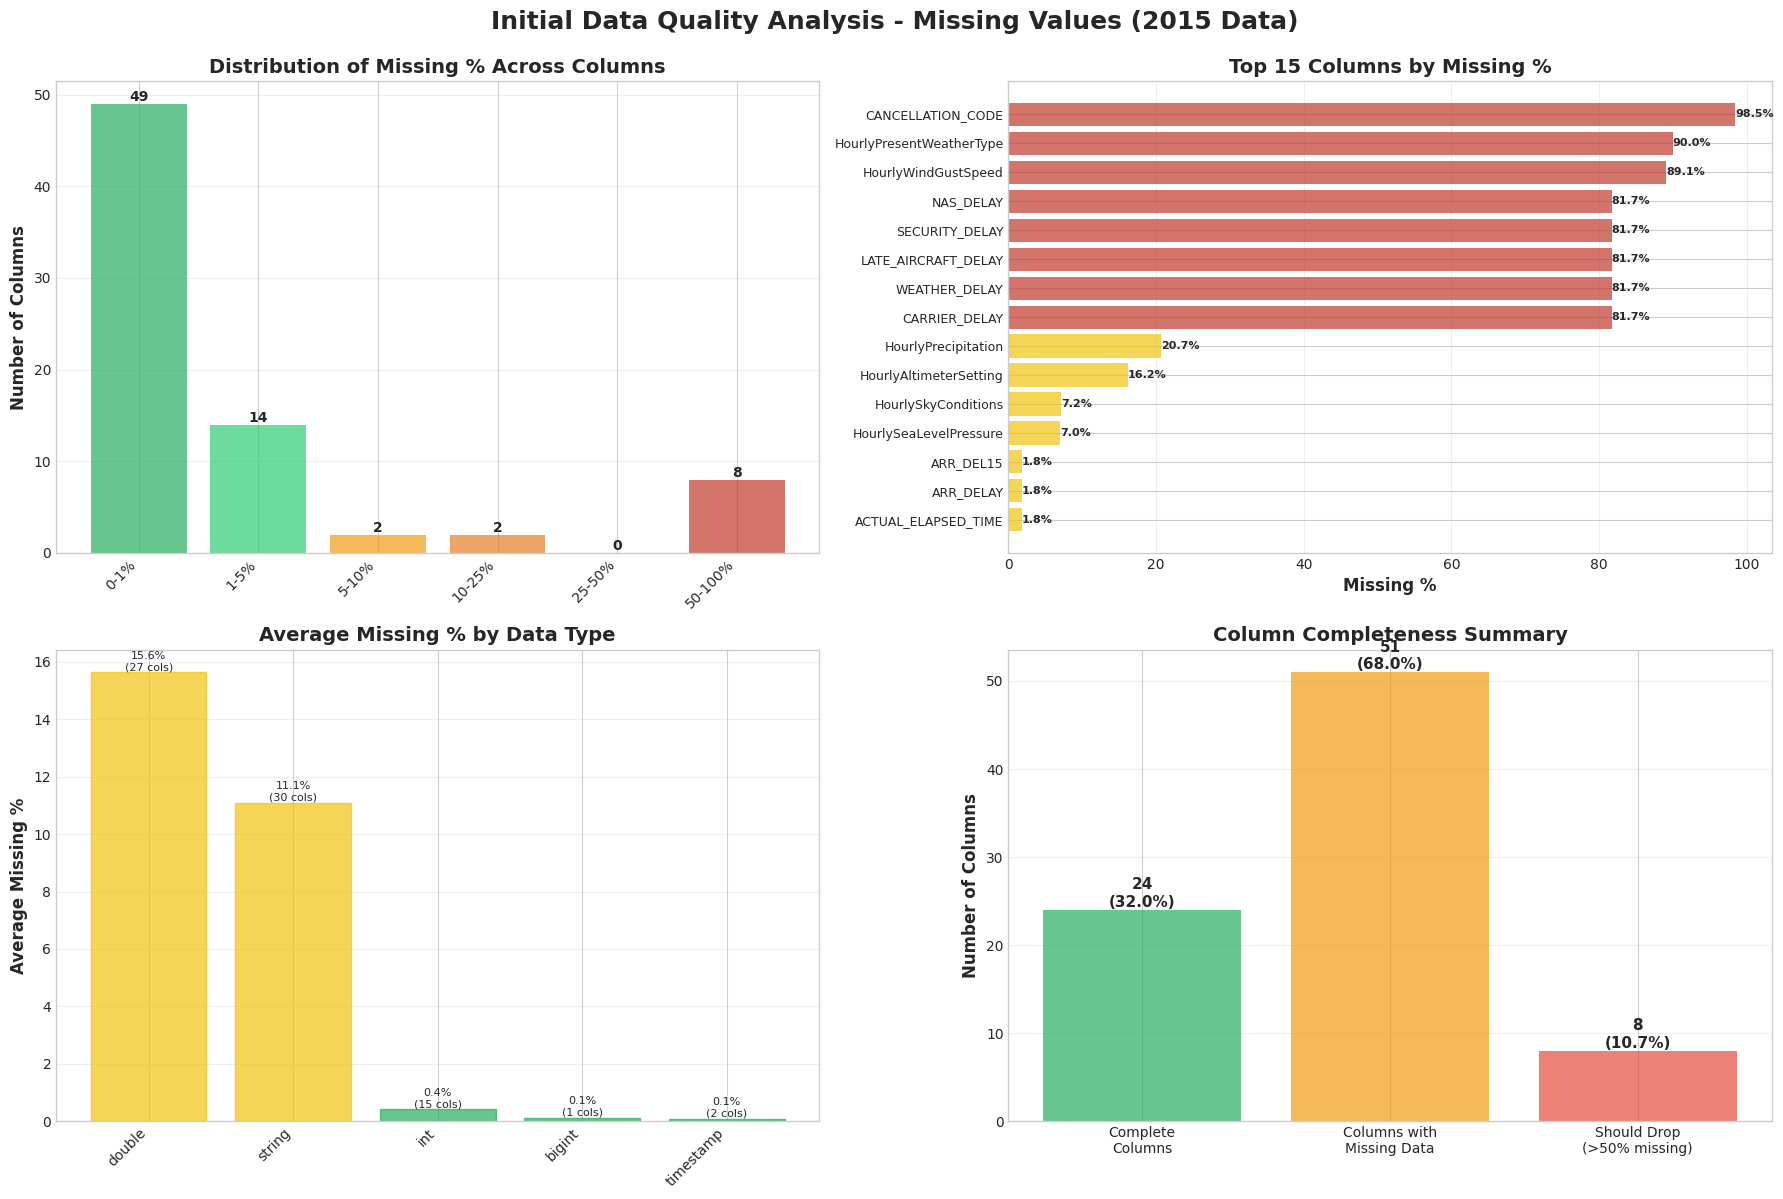


SECTION 6: CATEGORICAL CARDINALITY ANALYSIS

Found 30 categorical (string) columns

Analyzing cardinality...

 Cardinality Summary:
----------------------------------------------------------------------------------------------------


,Column,Distinct_Values,Null_Count,Cardinality_Ratio,Category
0,flight_id,5819079,0,1.000000e+00,Extremely High (>50% unique)
25,HourlySkyConditions,116881,416946,2.008582e-02,Very High (>100)
6,TAIL_NUM,4897,14721,8.415421e-04,Very High (>100)
22,HourlyStationPressure,1001,62323,1.720203e-04,Very High (>100)
26,HourlyPresentWeatherType,644,5236928,1.106704e-04,Very High (>100)
3,FL_DATE,365,0,6.272470e-05,Very High (>100)
10,DEST,322,0,5.533522e-05,Very High (>100)
7,ORIGIN,322,0,5.533522e-05,Very High (>100)
2,dest_station_id,320,2762,5.499152e-05,Very High (>100)
1,origin_station_id,320,2763,5.499152e-05,Very High (>100)



Encoding Recommendations:
----------------------------------------------------------------------------------------------------

Low (2-10): 3 columns
  → Strategy: One-hot encode (safe)
    • CANCELLATION_CODE: 4 values
    • origin_type: 3 values
    • dest_type: 3 values

Medium (11-50): 2 columns
  → Strategy: One-hot encode (safe)
    • OP_CARRIER: 14 values
    • OP_UNIQUE_CARRIER: 14 values

High (51-100): 6 columns
  → Strategy: Target encoding or frequency encoding
    • HourlyVisibility: 84 values
    • HourlyWindSpeed: 75 values
    • HourlyWindGustSpeed: 60 values
    • HourlyWindDirection: 53 values
    • ORIGIN_STATE_ABR: 53 values
    • DEST_STATE_ABR: 53 values

Very High (>100): 18 columns
  → Strategy: Target encoding or frequency encoding
    • HourlySkyConditions: 116,881 values
    • TAIL_NUM: 4,897 values
    • HourlyStationPressure: 1,001 values
    • HourlyPresentWeatherType: 644 values
    • FL_DATE: 365 values
    • DEST: 322 values
    • ORIGIN: 322 values
  

,Column,Category,Functional Type,Description,Expected Type,Actual Type,Action
0,flight_id,Identifier,Primary Key,Unique flight identifier (composite key),string,string,Keep for joins/tracking
1,prediction_utc,Temporal,Prediction Timestamp,T-2h before scheduled departure (UTC),timestamp,timestamp,Critical - defines prediction cutoff
2,origin_obs_utc,Weather Metadata,Observation Timestamp,Weather observation time (UTC),timestamp,timestamp,Keep for validation
3,asof_minutes,Weather Metadata,Time Lag,Minutes between weather obs and prediction,long,bigint,Keep - create feature
4,origin_station_id,Weather Metadata,Station ID,NOAA weather station ID for origin,string,string,Drop after validation
5,dest_station_id,Weather Metadata,Station ID,NOAA weather station ID for destination,string,string,Drop after validation
6,FL_DATE,Temporal,Flight Date,Date of flight,date (currently string),string,Convert to date type
7,YEAR,Temporal,Year,Year of flight (2015),integer,int,Keep
8,QUARTER,Temporal,Quarter (Ordinal),Quarter (1-4),integer,int,Keep
9,MONTH,Temporal,Month (Ordinal),Month (1-12),integer,int,Keep



✓ Appendix B1 saved to: /dbfs/student-groups/Group_4_4/appendix_b1_column_classification_2015.csv

 Summary by Category:
----------------------------------------------------------------------------------------------------


,Category,Count
5,Leakage,16
11,Weather Features,14
12,Weather Metadata,10
10,Temporal,9
1,Destination Airport,5
7,Origin Airport,5
0,Carrier,4
3,Flight Characteristics,3
6,Operational,3
8,Origin Geography,2



 Summary by Action Type:
----------------------------------------------------------------------------------------------------
  • Remove/Drop: 40 columns
  • Convert/Cast: 16 columns
  • Encode: 5 columns
  • Keep: 21 columns
  • Clean: 3 columns

SAVING CHECKPOINT 1 ANALYSIS REPORT

✓ Report saved to: /dbfs/student-groups/Group_4_4/checkpoint1_analysis_report.txt

CHECKPOINT 1 ANALYSIS COMPLETE

 Generated Files:
  1. Visualization: /dbfs/student-groups/Group_4_4/checkpoint1_missing_analysis.png
  2. Appendix B1: /dbfs/student-groups/Group_4_4/appendix_b1_column_classification_2015.csv
  3. Report: /dbfs/student-groups/Group_4_4/checkpoint1_analysis_report.txt

Ready to proceed with data cleaning!


In [0]:
# ============================================================================
# INITIAL DATA ANALYSIS - CHECKPOINT 1: RAW JOINED DATA (2015)
# ============================================================================
# This analysis runs at the START of the Data Cleaning Notebook
# Location: Insert immediately after loading JOINED_1Y_2015.parquet
# ============================================================================

print("=" * 100)
print("CHECKPOINT 1 ANALYSIS: INITIAL JOINED DATA (2015)")
print("Raw Data - Before Any Cleaning or Processing")
print("=" * 100)


# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ============================================================================
# SECTION 1: BASIC DATASET INFORMATION
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 1: BASIC DATASET INFORMATION")
print("=" * 100)

# Load data
BASE_PATH = "dbfs:/student-groups/Group_4_4/"
df_initial = spark.read.parquet(f"{BASE_PATH}JOINED_1Y_2015.parquet")

# Basic counts
total_rows = df_initial.count()
total_cols = len(df_initial.columns)
total_cells = total_rows * total_cols

print(f"\nDataset Dimensions:")
print(f"  • Total Rows: {total_rows:,}")
print(f"  • Total Columns: {total_cols}")
print(f"  • Total Cells: {total_cells:,}")

# Column types
col_types = [df_initial.schema[c].dataType.simpleString() for c in df_initial.columns]
type_counts = Counter(col_types)

print(f"\nData Types Distribution:")
for dtype, count in sorted(type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  • {dtype}: {count} columns ({count/total_cols*100:.1f}%)")

# Memory estimate (rough)
avg_row_size = 500  # bytes, rough estimate
estimated_size_gb = (total_rows * avg_row_size) / (1024**3)
print(f"\nEstimated Dataset Size: ~{estimated_size_gb:.2f} GB")

# ============================================================================
# SECTION 2: TEMPORAL COVERAGE
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 2: TEMPORAL COVERAGE")
print("=" * 100)

# Date range
date_stats = df_initial.select(
    F.min("FL_DATE").alias("earliest_date"),
    F.max("FL_DATE").alias("latest_date"),
    F.countDistinct("FL_DATE").alias("unique_dates")
).first()

print(f"\nDate Range:")
print(f"  • Earliest Flight: {date_stats['earliest_date']}")
print(f"  • Latest Flight: {date_stats['latest_date']}")
print(f"  • Unique Dates: {date_stats['unique_dates']:,}")
print(f"  • Expected Days in 2015: 365")
print(f"  • Coverage: {date_stats['unique_dates']/365*100:.1f}%")

# Flights by quarter
print(f"\nFlights by Quarter:")
quarter_dist = df_initial.groupBy("QUARTER").count().orderBy("QUARTER").collect()
for row in quarter_dist:
    pct = (row['count'] / total_rows) * 100
    print(f"  • Q{row['QUARTER']}: {row['count']:,} flights ({pct:.1f}%)")

# Flights by month
print(f"\nFlights by Month:")
month_dist = df_initial.groupBy("MONTH").count().orderBy("MONTH").collect()
for row in month_dist:
    pct = (row['count'] / total_rows) * 100
    print(f"  • Month {row['MONTH']:2d}: {row['count']:,} flights ({pct:.1f}%)")

# ============================================================================
# SECTION 3: TARGET VARIABLE ANALYSIS
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 3: TARGET VARIABLE ANALYSIS")
print("=" * 100)

# Check if target exists
if "DEP_DEL15" in df_initial.columns:
    # Target distribution
    target_stats = df_initial.groupBy("DEP_DEL15").count().collect()
    target_null = df_initial.filter(col("DEP_DEL15").isNull()).count()
    
    print(f"\nTarget Variable: DEP_DEL15")
    print(f"  Distribution:")
    
    for row in sorted(target_stats, key=lambda x: x['DEP_DEL15'] if x['DEP_DEL15'] is not None else -1):
        if row['DEP_DEL15'] is not None:
            pct = (row['count'] / total_rows) * 100
            label = "On-Time" if row['DEP_DEL15'] == 0.0 else "Delayed (≥15min)"
            print(f"    • {label} ({int(row['DEP_DEL15'])}): {row['count']:,} ({pct:.2f}%)")
    
    if target_null > 0:
        pct = (target_null / total_rows) * 100
        print(f"    NULL: {target_null:,} ({pct:.2f}%)")
        print(f"         → These rows MUST be removed (cannot train without target)")
    
    # Class imbalance ratio
    delayed = df_initial.filter(col("DEP_DEL15") == 1.0).count()
    on_time = df_initial.filter(col("DEP_DEL15") == 0.0).count()
    
    if delayed > 0 and on_time > 0:
        imbalance_ratio = max(on_time, delayed) / min(on_time, delayed)
        print(f"\n  Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
        
        if imbalance_ratio > 3:
            print(f"      Significant imbalance - will need SMOTE/upsampling/downsampling")
        else:
            print(f"      ✓ Relatively balanced")
else:
    print("Target variable DEP_DEL15 not found!")

# ============================================================================
# SECTION 4: COMPREHENSIVE MISSING VALUE ANALYSIS
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 4: COMPREHENSIVE MISSING VALUE ANALYSIS")
print("=" * 100)

print("\nCalculating missing values for all columns...")

missing_stats = []

for col_name in df_initial.columns:
    col_type = dict(df_initial.dtypes)[col_name]
    
    # Count nulls and NaNs (for numeric types)
    if col_type in ['double', 'float']:
        null_count = df_initial.filter(
            col(col_name).isNull() | isnan(col(col_name))
        ).count()
    else:
        null_count = df_initial.filter(col(col_name).isNull()).count()
    
    null_pct = (null_count / total_rows) * 100
    present_count = total_rows - null_count
    present_pct = 100 - null_pct
    
    missing_stats.append({
        'Column': col_name,
        'Data_Type': col_type,
        'Missing_Count': null_count,
        'Missing_Pct': null_pct,
        'Present_Count': present_count,
        'Present_Pct': present_pct
    })

# Convert to pandas for analysis
missing_df = pd.DataFrame(missing_stats)
missing_df = missing_df.sort_values('Missing_Pct', ascending=False)

# Overall statistics
total_missing = missing_df['Missing_Count'].sum()
overall_missing_pct = (total_missing / total_cells) * 100

print(f"\n Overall Missing Data Statistics:")
print(f"  • Total Missing Values: {int(total_missing):,} / {total_cells:,}")
print(f"  • Overall Missing %: {overall_missing_pct:.2f}%")
print(f"  • Columns with ANY missing: {len(missing_df[missing_df['Missing_Count'] > 0])}/{total_cols}")
print(f"  • Columns completely full: {len(missing_df[missing_df['Missing_Count'] == 0])}/{total_cols}")

# Categorize by severity
print(f"\nMissing Data Severity Breakdown:")
severity_levels = [
    (90, 100, "Extreme (90-100% missing)"),
    (50, 90, "High (50-90% missing)"),
    (10, 50, "Moderate (10-50% missing)"),
    (1, 10, "Low (1-10% missing)"),
    (0, 1, "Minimal (<1% missing)")
]

for min_pct, max_pct, label in severity_levels:
    count = len(missing_df[(missing_df['Missing_Pct'] >= min_pct) & (missing_df['Missing_Pct'] < max_pct)])
    if count > 0:
        print(f"  • {label}: {count} columns")

# Top 20 columns with most missing
print(f"\n🔝 Top 20 Columns with Most Missing Data:")
print("-" * 100)
display(missing_df.head(20)[['Column', 'Data_Type', 'Missing_Count', 'Missing_Pct']])

# Columns with >50% missing (candidates for dropping)
high_missing = missing_df[missing_df['Missing_Pct'] > 50]
if len(high_missing) > 0:
    print(f"\nCRITICAL: {len(high_missing)} columns have >50% missing data")
    print("   → Recommendation: DROP these columns entirely")
    print("\nColumns to drop:")
    for _, row in high_missing.iterrows():
        print(f"  • {row['Column']}: {row['Missing_Pct']:.1f}% missing ({row['Data_Type']})")

# ============================================================================
# SECTION 5: MISSING DATA VISUALIZATIONS
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 5: MISSING DATA VISUALIZATIONS")
print("=" * 100)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Initial Data Quality Analysis - Missing Values (2015 Data)', 
             fontsize=18, fontweight='bold', y=0.995)

# Plot 1: Missing % Distribution
ax1 = axes[0, 0]
missing_bins = [0, 1, 5, 10, 25, 50, 100]
missing_labels = ['0-1%', '1-5%', '5-10%', '10-25%', '25-50%', '50-100%']
missing_df['missing_bin'] = pd.cut(missing_df['Missing_Pct'], bins=missing_bins, labels=missing_labels, include_lowest=True)
bin_counts = missing_df['missing_bin'].value_counts().sort_index()

colors = ['#27ae60', '#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
ax1.bar(range(len(bin_counts)), bin_counts.values, color=colors, alpha=0.7)
ax1.set_xticks(range(len(bin_counts)))
ax1.set_xticklabels(bin_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Number of Columns', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Missing % Across Columns', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(bin_counts.values):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Plot 2: Top 15 Worst Columns
ax2 = axes[0, 1]
top15 = missing_df.head(15)
y_pos = np.arange(len(top15))

colors_severity = []
for pct in top15['Missing_Pct']:
    if pct > 75:
        colors_severity.append('#c0392b')
    elif pct > 50:
        colors_severity.append('#e74c3c')
    elif pct > 25:
        colors_severity.append('#f39c12')
    else:
        colors_severity.append('#f1c40f')

bars = ax2.barh(y_pos, top15['Missing_Pct'], color=colors_severity, alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top15['Column'], fontsize=9)
ax2.set_xlabel('Missing %', fontsize=12, fontweight='bold')
ax2.set_title('Top 15 Columns by Missing %', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, top15['Missing_Pct'])):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', ha='left', va='center', fontsize=8, fontweight='bold')

# Plot 3: Missing by Data Type
ax3 = axes[1, 0]
type_missing = missing_df.groupby('Data_Type')['Missing_Pct'].agg(['mean', 'count'])
type_missing = type_missing.sort_values('mean', ascending=False)

bars = ax3.bar(range(len(type_missing)), type_missing['mean'], alpha=0.7)
ax3.set_xticks(range(len(type_missing)))
ax3.set_xticklabels(type_missing.index, rotation=45, ha='right')
ax3.set_ylabel('Average Missing %', fontsize=12, fontweight='bold')
ax3.set_title('Average Missing % by Data Type', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Color by severity
for i, (bar, val) in enumerate(zip(bars, type_missing['mean'])):
    if val > 50:
        bar.set_color('#e74c3c')
    elif val > 25:
        bar.set_color('#f39c12')
    elif val > 10:
        bar.set_color('#f1c40f')
    else:
        bar.set_color('#27ae60')
    
    # Add count label
    count = type_missing.iloc[i]['count']
    ax3.text(i, val, f"{val:.1f}%\n({int(count)} cols)", 
            ha='center', va='bottom', fontsize=8)

# Plot 4: Complete vs Incomplete Summary
ax4 = axes[1, 1]
complete_cols = len(missing_df[missing_df['Missing_Count'] == 0])
incomplete_cols = total_cols - complete_cols
drop_candidates = len(missing_df[missing_df['Missing_Pct'] > 50])

categories = ['Complete\nColumns', 'Columns with\nMissing Data', 'Should Drop\n(>50% missing)']
values = [complete_cols, incomplete_cols, drop_candidates]
colors_summary = ['#27ae60', '#f39c12', '#e74c3c']

bars = ax4.bar(categories, values, color=colors_summary, alpha=0.7)
ax4.set_ylabel('Number of Columns', fontsize=12, fontweight='bold')
ax4.set_title('Column Completeness Summary', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}\n({val/total_cols*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
output_path = '/dbfs/student-groups/Group_4_4/checkpoint1_missing_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Visualization saved: {output_path}")
plt.show()

# ============================================================================
# SECTION 6: CATEGORICAL CARDINALITY ANALYSIS
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 6: CATEGORICAL CARDINALITY ANALYSIS")
print("=" * 100)

# Get string columns
categorical_cols = [field.name for field in df_initial.schema.fields 
                   if field.dataType.simpleString() == 'string']

print(f"\nFound {len(categorical_cols)} categorical (string) columns")
print("\nAnalyzing cardinality...")

cardinality_stats = []

for col_name in categorical_cols:
    distinct_count = df_initial.select(countDistinct(col(col_name))).first()[0]
    null_count = df_initial.filter(col(col_name).isNull()).count()
    cardinality_ratio = distinct_count / total_rows
    
    # Categorize
    if distinct_count <= 2:
        category = "Binary"
    elif distinct_count <= 10:
        category = "Low (2-10)"
    elif distinct_count <= 50:
        category = "Medium (11-50)"
    elif distinct_count <= 100:
        category = "High (51-100)"
    elif cardinality_ratio > 0.5:
        category = "Extremely High (>50% unique)"
    else:
        category = "Very High (>100)"
    
    cardinality_stats.append({
        'Column': col_name,
        'Distinct_Values': distinct_count,
        'Null_Count': null_count,
        'Cardinality_Ratio': cardinality_ratio,
        'Category': category
    })

cardinality_df = pd.DataFrame(cardinality_stats)
cardinality_df = cardinality_df.sort_values('Distinct_Values', ascending=False)

print("\n Cardinality Summary:")
print("-" * 100)
display(cardinality_df)

# Encoding recommendations
print("\nEncoding Recommendations:")
print("-" * 100)

for category in ["Binary", "Low (2-10)", "Medium (11-50)", "High (51-100)", 
                 "Very High (>100)", "Extremely High (>50% unique)"]:
    cols_in_cat = cardinality_df[cardinality_df['Category'] == category]
    if len(cols_in_cat) > 0:
        print(f"\n{category}: {len(cols_in_cat)} columns")
        
        if category == "Binary":
            print("  → Strategy: Label encode (0/1) or keep as-is")
        elif category in ["Low (2-10)", "Medium (11-50)"]:
            print("  → Strategy: One-hot encode (safe)")
        elif category in ["High (51-100)", "Very High (>100)"]:
            print("  → Strategy: Target encoding or frequency encoding")
        elif category == "Extremely High (>50% unique)":
            print("  → Strategy: DROP (likely identifier) or embed if sequential")
        
        for _, row in cols_in_cat.iterrows():
            print(f"    • {row['Column']}: {row['Distinct_Values']:,} values")

# ============================================================================
# SECTION 7: DATA TYPE ISSUES DETECTION
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 7: DATA TYPE ISSUES DETECTION")
print("=" * 100)

print("\nChecking for data type inconsistencies...\n")

# Weather columns that should be numeric but are strings
weather_string_cols = [
    'HourlyDryBulbTemperature', 'HourlyDewPointTemperature', 'HourlyWetBulbTemperature',
    'HourlyPrecipitation', 'HourlyWindSpeed', 'HourlyWindDirection', 'HourlyWindGustSpeed',
    'HourlyVisibility', 'HourlyRelativeHumidity', 'HourlyStationPressure',
    'HourlySeaLevelPressure', 'HourlyAltimeterSetting'
]

print("Weather Columns Stored as Strings (should be numeric):")
for col_name in weather_string_cols:
    if col_name in df_initial.columns:
        print(f"  • {col_name}: string → needs conversion to double")

# Check for quality flags (sample data)
print("\n🔬 Checking for NOAA quality flags (e.g., 's' suffix)...")
sample_temp = df_initial.select("HourlyDryBulbTemperature").limit(100).collect()
has_s_flag = any('s' in str(row[0]) for row in sample_temp if row[0] is not None)
if has_s_flag:
    print("  Found 's' quality flags in temperature data")
    print("      → Need: regexp_replace to strip 's' before casting")

# Check for precipitation 'T' (trace)
sample_precip = df_initial.select("HourlyPrecipitation").limit(100).collect()
has_t_flag = any(str(row[0]) == 'T' for row in sample_precip if row[0] is not None)
if has_t_flag:
    print("  Found 'T' (trace) in precipitation data")
    print("      → Need: Convert 'T' to 0.0 before casting")

# FL_DATE should be date type
fl_date_type = dict(df_initial.dtypes)['FL_DATE']
print(f"\ FL_DATE type: {fl_date_type}")
if fl_date_type == 'string':
    print("   FL_DATE is string → should convert to date type")

# Time columns (HHMM format)
print(f"\nTime Columns (HHMM format):")
time_cols = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'DEP_TIME', 'ARR_TIME', 'WHEELS_OFF', 'WHEELS_ON']
for col_name in time_cols:
    if col_name in df_initial.columns:
        col_type = dict(df_initial.dtypes)[col_name]
        print(f"  • {col_name}: {col_type}")

# ============================================================================
# SECTION 8: LEAKAGE DETECTION
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 8: DATA LEAKAGE DETECTION")
print("=" * 100)

print("\nChecking for features that leak future information...\n")

leakage_features = {
    "Actual Times (known only after flight)": [
        'DEP_TIME', 'ARR_TIME', 'WHEELS_OFF', 'WHEELS_ON'
    ],
    "Actual Delays (target-related)": [
        'DEP_DELAY', 'ARR_DELAY', 'ARR_DEL15'
    ],
    "Taxi Times (known only after departure)": [
        'TAXI_OUT', 'TAXI_IN'
    ],
    "Flight Durations (known only after completion)": [
        'ACTUAL_ELAPSED_TIME', 'AIR_TIME'
    ],
    "Delay Breakdowns (known only after delay)": [
        'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 
        'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'
    ]
}

print("  Leakage Features Present in Dataset:")
print("   (These MUST be removed before training)\n")

total_leakage = 0
for category, features in leakage_features.items():
    existing = [f for f in features if f in df_initial.columns]
    if existing:
        print(f"{category}:")
        for feat in existing:
            print(f"  • {feat}")
            total_leakage += 1
        print()

print(f"Total Leakage Features to Remove: {total_leakage}")

# Check weather timestamp leakage
print("\nWeather Timestamp Validation:")
print("   Checking if weather observations are BEFORE prediction time (T-2h)...")

weather_leakage = df_initial.filter(
    col("origin_obs_utc") > col("prediction_utc")
).count()

if weather_leakage > 0:
    pct = (weather_leakage / total_rows) * 100
    print(f"   {weather_leakage:,} flights ({pct:.2f}%) have weather AFTER prediction time")
    print(f"       → DATA QUALITY ISSUE: Weather should be recorded BEFORE T-2h")
else:
    print(f"   ✓ All weather observations are before prediction time")

# Check average weather lag
avg_lag = df_initial.select(
    F.avg("asof_minutes").alias("avg_lag_minutes")
).first()['avg_lag_minutes']

print(f"\nAverage weather observation lag: {avg_lag:.1f} minutes")
print(f"   Expected: ~120 minutes (2 hours before departure)")

# ============================================================================
# SECTION 9: BASIC STATISTICS BY FEATURE TYPE
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 9: BASIC STATISTICS BY FEATURE TYPE")
print("=" * 100)

# Numeric features summary
numeric_cols = [field.name for field in df_initial.schema.fields 
               if field.dataType.simpleString() in ['double', 'float', 'int', 'integer', 'bigint', 'long']]

print(f"\nNumeric Features Summary (sample of key features):")
print("-" * 100)

key_numeric = ['DISTANCE', 'CRS_ELAPSED_TIME', 'DEP_DELAY', 'ARR_DELAY', 
               'origin_station_dis', 'dest_station_dis']
existing_numeric = [c for c in key_numeric if c in df_initial.columns]

if existing_numeric:
    df_initial.select(existing_numeric).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

# Carrier distribution
print(f"\nTop 10 Carriers by Flight Count:")
print("-" * 100)
carrier_dist = df_initial.groupBy("OP_UNIQUE_CARRIER").count() \
    .orderBy(F.desc("count")).limit(10).collect()

for i, row in enumerate(carrier_dist, 1):
    pct = (row['count'] / total_rows) * 100
    print(f"  {i:2d}. {row['OP_UNIQUE_CARRIER']}: {row['count']:,} flights ({pct:.2f}%)")

# Top origin airports
print(f"\nTop 10 Origin Airports by Flight Count:")
print("-" * 100)
origin_dist = df_initial.groupBy("ORIGIN").count() \
    .orderBy(F.desc("count")).limit(10).collect()

for i, row in enumerate(origin_dist, 1):
    pct = (row['count'] / total_rows) * 100
    print(f"  {i:2d}. {row['ORIGIN']}: {row['count']:,} flights ({pct:.2f}%)")

# ============================================================================
# SECTION 10: KEY RECOMMENDATIONS
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 10: DATA CLEANING RECOMMENDATIONS")
print("=" * 100)

recommendations = []

# Missing data
if len(missing_df[missing_df['Missing_Pct'] > 50]) > 0:
    recommendations.append(f"1. DROP {len(missing_df[missing_df['Missing_Pct'] > 50])} columns with >50% missing data")

# Target nulls
target_nulls = df_initial.filter(col("DEP_DEL15").isNull()).count()
if target_nulls > 0:
    recommendations.append(f"2. REMOVE {target_nulls:,} rows with null target (DEP_DEL15)")

# Leakage
if total_leakage > 0:
    recommendations.append(f"3. REMOVE {total_leakage} leakage features (actual times, delays, etc.)")

# Data types
recommendations.append(f"4. CAST {len(weather_string_cols)} weather columns from string to double")
recommendations.append(f"5. CONVERT FL_DATE from string to date type")

# Weather quality
if has_s_flag or has_t_flag:
    recommendations.append(f"6. CLEAN weather quality flags ('s' suffix, 'T' for trace)")

# Duplicates
recommendations.append(f"7. CHECK and REMOVE duplicate rows")

# Cancelled/diverted
recommendations.append(f"8. FILTER out cancelled and diverted flights")

# Geographic nulls
geo_cols = ['origin_airport_lat', 'origin_airport_lon', 'dest_airport_lat', 'dest_airport_lon']
geo_nulls = sum(df_initial.filter(col(c).isNull()).count() for c in geo_cols if c in df_initial.columns)
if geo_nulls > 0:
    recommendations.append(f"9. HANDLE {geo_nulls:,} missing geographic coordinates")

# Class imbalance
if 'imbalance_ratio' in locals() and imbalance_ratio > 3:
    recommendations.append(f"10. HANDLE class imbalance (ratio: {imbalance_ratio:.2f}:1)")

print("\nPriority Actions:")
for rec in recommendations:
    print(f"  {rec}")

# ============================================================================
# APPENDIX B1: COMPREHENSIVE COLUMN CLASSIFICATION
# ============================================================================

print("\n" + "=" * 100)
print("APPENDIX B1: COMPREHENSIVE COLUMN CLASSIFICATION")
print("Checkpoint 1: Initial Joined Data (2015)")
print("=" * 100)

# Define column categories and descriptions
column_classification = {
    # IDENTIFIERS
    "flight_id": {
        "category": "Identifier",
        "functional_type": "Primary Key",
        "description": "Unique flight identifier (composite key)",
        "expected_type": "string",
        "action": "Keep for joins/tracking"
    },
    
    # TEMPORAL - PREDICTION
    "prediction_utc": {
        "category": "Temporal",
        "functional_type": "Prediction Timestamp",
        "description": "T-2h before scheduled departure (UTC)",
        "expected_type": "timestamp",
        "action": "Critical - defines prediction cutoff"
    },
    
    # TEMPORAL - FLIGHT
    "FL_DATE": {
        "category": "Temporal",
        "functional_type": "Flight Date",
        "description": "Date of flight",
        "expected_type": "date (currently string)",
        "action": "Convert to date type"
    },
    "YEAR": {
        "category": "Temporal",
        "functional_type": "Year",
        "description": "Year of flight (2015)",
        "expected_type": "integer",
        "action": "Keep"
    },
    "QUARTER": {
        "category": "Temporal",
        "functional_type": "Quarter (Ordinal)",
        "description": "Quarter (1-4)",
        "expected_type": "integer",
        "action": "Keep"
    },
    "MONTH": {
        "category": "Temporal",
        "functional_type": "Month (Ordinal)",
        "description": "Month (1-12)",
        "expected_type": "integer",
        "action": "Keep"
    },
    "DAY_OF_MONTH": {
        "category": "Temporal",
        "functional_type": "Day (Ordinal)",
        "description": "Day of month (1-31)",
        "expected_type": "integer",
        "action": "Keep"
    },
    "DAY_OF_WEEK": {
        "category": "Temporal",
        "functional_type": "Day of Week (Ordinal)",
        "description": "Day of week (1-7)",
        "expected_type": "integer",
        "action": "Keep"
    },
    "CRS_DEP_TIME": {
        "category": "Temporal",
        "functional_type": "Scheduled Time (Cyclic)",
        "description": "Scheduled departure time (HHMM format)",
        "expected_type": "integer",
        "action": "Keep - convert to cyclic features"
    },
    "CRS_ARR_TIME": {
        "category": "Temporal",
        "functional_type": "Scheduled Time (Cyclic)",
        "description": "Scheduled arrival time (HHMM format)",
        "expected_type": "integer",
        "action": "Keep - convert to cyclic features"
    },
    
    # CARRIER
    "OP_UNIQUE_CARRIER": {
        "category": "Carrier",
        "functional_type": "Categorical (Nominal)",
        "description": "Unique carrier code (e.g., AA, DL, UA)",
        "expected_type": "string",
        "action": "Encode (one-hot or target)"
    },
    "OP_CARRIER": {
        "category": "Carrier",
        "functional_type": "Categorical (Nominal)",
        "description": "Operating carrier (duplicate of OP_UNIQUE_CARRIER)",
        "expected_type": "string",
        "action": "Consider dropping (redundant)"
    },
    "OP_CARRIER_FL_NUM": {
        "category": "Carrier",
        "functional_type": "Flight Number",
        "description": "Flight number",
        "expected_type": "integer",
        "action": "Keep"
    },
    "TAIL_NUM": {
        "category": "Carrier",
        "functional_type": "Aircraft ID (High Cardinality)",
        "description": "Aircraft tail number",
        "expected_type": "string",
        "action": "Use for aircraft lag features, then drop"
    },
    
    # ORIGIN
    "ORIGIN": {
        "category": "Origin Airport",
        "functional_type": "Categorical (High Cardinality)",
        "description": "Origin airport IATA code",
        "expected_type": "string",
        "action": "Target encode"
    },
    "ORIGIN_AIRPORT_ID": {
        "category": "Origin Airport",
        "functional_type": "Airport ID",
        "description": "Origin airport numeric ID",
        "expected_type": "integer",
        "action": "Consider dropping (redundant with ORIGIN)"
    },
    "ORIGIN_CITY_NAME": {
        "category": "Origin Airport",
        "functional_type": "City Name",
        "description": "Origin city name",
        "expected_type": "string",
        "action": "Drop (redundant)"
    },
    "ORIGIN_STATE_ABR": {
        "category": "Origin Airport",
        "functional_type": "State Code",
        "description": "Origin state abbreviation",
        "expected_type": "string",
        "action": "Consider one-hot encoding"
    },
    "origin_type": {
        "category": "Origin Airport",
        "functional_type": "Airport Type",
        "description": "Airport size (large/medium/small)",
        "expected_type": "string",
        "action": "One-hot encode"
    },
    "origin_airport_lat": {
        "category": "Origin Geography",
        "functional_type": "Latitude",
        "description": "Origin airport latitude",
        "expected_type": "double",
        "action": "Keep"
    },
    "origin_airport_lon": {
        "category": "Origin Geography",
        "functional_type": "Longitude",
        "description": "Origin airport longitude",
        "expected_type": "double",
        "action": "Keep"
    },
    
    # DESTINATION
    "DEST": {
        "category": "Destination Airport",
        "functional_type": "Categorical (High Cardinality)",
        "description": "Destination airport IATA code",
        "expected_type": "string",
        "action": "Target encode"
    },
    "DEST_AIRPORT_ID": {
        "category": "Destination Airport",
        "functional_type": "Airport ID",
        "description": "Destination airport numeric ID",
        "expected_type": "integer",
        "action": "Consider dropping (redundant)"
    },
    "DEST_CITY_NAME": {
        "category": "Destination Airport",
        "functional_type": "City Name",
        "description": "Destination city name",
        "expected_type": "string",
        "action": "Drop (redundant)"
    },
    "DEST_STATE_ABR": {
        "category": "Destination Airport",
        "functional_type": "State Code",
        "description": "Destination state abbreviation",
        "expected_type": "string",
        "action": "Consider one-hot encoding"
    },
    "dest_type": {
        "category": "Destination Airport",
        "functional_type": "Airport Type",
        "description": "Airport size (large/medium/small)",
        "expected_type": "string",
        "action": "One-hot encode"
    },
    "dest_airport_lat": {
        "category": "Destination Geography",
        "functional_type": "Latitude",
        "description": "Destination airport latitude",
        "expected_type": "double",
        "action": "Keep"
    },
    "dest_airport_lon": {
        "category": "Destination Geography",
        "functional_type": "Longitude",
        "description": "Destination airport longitude",
        "expected_type": "double",
        "action": "Keep"
    },
    
    # FLIGHT CHARACTERISTICS
    "DISTANCE": {
        "category": "Flight Characteristics",
        "functional_type": "Continuous",
        "description": "Flight distance (miles)",
        "expected_type": "double",
        "action": "Keep + create log_distance"
    },
    "DISTANCE_GROUP": {
        "category": "Flight Characteristics",
        "functional_type": "Categorical (Ordinal)",
        "description": "Distance category",
        "expected_type": "integer",
        "action": "Keep or drop (derived from DISTANCE)"
    },
    "CRS_ELAPSED_TIME": {
        "category": "Flight Characteristics",
        "functional_type": "Continuous",
        "description": "Scheduled flight duration (minutes)",
        "expected_type": "double",
        "action": "Keep"
    },
    
    # WEATHER - ORIGIN
    "origin_obs_utc": {
        "category": "Weather Metadata",
        "functional_type": "Observation Timestamp",
        "description": "Weather observation time (UTC)",
        "expected_type": "timestamp",
        "action": "Keep for validation"
    },
    "asof_minutes": {
        "category": "Weather Metadata",
        "functional_type": "Time Lag",
        "description": "Minutes between weather obs and prediction",
        "expected_type": "long",
        "action": "Keep - create feature"
    },
    "origin_station_id": {
        "category": "Weather Metadata",
        "functional_type": "Station ID",
        "description": "NOAA weather station ID for origin",
        "expected_type": "string",
        "action": "Drop after validation"
    },
    "dest_station_id": {
        "category": "Weather Metadata",
        "functional_type": "Station ID",
        "description": "NOAA weather station ID for destination",
        "expected_type": "string",
        "action": "Drop after validation"
    },
    "origin_station_lat": {
        "category": "Weather Metadata",
        "functional_type": "Station Latitude",
        "description": "Weather station latitude",
        "expected_type": "double",
        "action": "Drop (redundant)"
    },
    "origin_station_lon": {
        "category": "Weather Metadata",
        "functional_type": "Station Longitude",
        "description": "Weather station longitude",
        "expected_type": "double",
        "action": "Drop (redundant)"
    },
    "dest_station_lat": {
        "category": "Weather Metadata",
        "functional_type": "Station Latitude",
        "description": "Weather station latitude",
        "expected_type": "double",
        "action": "Drop (redundant)"
    },
    "dest_station_lon": {
        "category": "Weather Metadata",
        "functional_type": "Station Longitude",
        "description": "Weather station longitude",
        "expected_type": "double",
        "action": "Drop (redundant)"
    },
    "origin_station_dis": {
        "category": "Weather Metadata",
        "functional_type": "Distance",
        "description": "Distance from origin airport to weather station (km)",
        "expected_type": "double",
        "action": "Keep or drop"
    },
    "dest_station_dis": {
        "category": "Weather Metadata",
        "functional_type": "Distance",
        "description": "Distance from dest airport to weather station (km)",
        "expected_type": "double",
        "action": "Keep or drop"
    },
    
    # WEATHER - MEASUREMENTS
    "HourlyDryBulbTemperature": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Temperature (°F) at origin",
        "expected_type": "double (currently string)",
        "action": "Clean 's' flag, cast to double, impute"
    },
    "HourlyDewPointTemperature": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Dew point temperature (°F)",
        "expected_type": "double (currently string)",
        "action": "Clean, cast, impute"
    },
    "HourlyWetBulbTemperature": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Wet bulb temperature (°F)",
        "expected_type": "double (currently string)",
        "action": "Clean, cast, impute or drop (correlated)"
    },
    "HourlyPrecipitation": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Precipitation (inches)",
        "expected_type": "double (currently string)",
        "action": "Convert 'T' to 0, cast, impute"
    },
    "HourlyWindSpeed": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Wind speed (mph)",
        "expected_type": "double (currently string)",
        "action": "Cast, impute"
    },
    "HourlyWindDirection": {
        "category": "Weather Features",
        "functional_type": "Continuous (Cyclic)",
        "description": "Wind direction (degrees, 0-360)",
        "expected_type": "double (currently string)",
        "action": "Cast, create sin/cos features"
    },
    "HourlyWindGustSpeed": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Wind gust speed (mph)",
        "expected_type": "double (currently string)",
        "action": "Cast, impute"
    },
    "HourlyVisibility": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Visibility (miles)",
        "expected_type": "double (currently string)",
        "action": "Cast, impute"
    },
    "HourlyRelativeHumidity": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Relative humidity (%)",
        "expected_type": "double (currently string)",
        "action": "Cast, impute"
    },
    "HourlyStationPressure": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Station pressure (mb)",
        "expected_type": "double (currently string)",
        "action": "Cast, impute or drop (correlated)"
    },
    "HourlySeaLevelPressure": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Sea level pressure (mb)",
        "expected_type": "double (currently string)",
        "action": "Cast, impute or drop (correlated)"
    },
    "HourlyAltimeterSetting": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Altimeter setting (inches Hg)",
        "expected_type": "double (currently string)",
        "action": "Cast, impute (keep for aviation)"
    },
    "HourlySkyConditions": {
        "category": "Weather Features",
        "functional_type": "Text/Categorical",
        "description": "Sky condition codes (CLR, SCT, OVC, etc.)",
        "expected_type": "string",
        "action": "Parse or drop (high cardinality)"
    },
    "HourlyPresentWeatherType": {
        "category": "Weather Features",
        "functional_type": "Text/Categorical",
        "description": "Weather type codes (RA=rain, BR=mist, etc.)",
        "expected_type": "string",
        "action": "Parse or drop (high cardinality)"
    },
    
    # TARGET VARIABLE
    "DEP_DEL15": {
        "category": "Target Variable",
        "functional_type": "Binary Target",
        "description": "Departure delay ≥15 minutes (0/1)",
        "expected_type": "integer (currently double)",
        "action": "Cast to int, remove nulls"
    },
    
    # LEAKAGE FEATURES (MUST REMOVE)
    "DEP_DELAY": {
        "category": "Leakage",
        "functional_type": "Actual Delay",
        "description": "Actual departure delay (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "ARR_DEL15": {
        "category": "Leakage",
        "functional_type": "Actual Delay",
        "description": "Arrival delay ≥15 minutes",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "ARR_DELAY": {
        "category": "Leakage",
        "functional_type": "Actual Delay",
        "description": "Actual arrival delay (minutes)",
        "expected_type": "double",
        "action": "REMOVE - leakage"
    },
    "DEP_TIME": {
        "category": "Leakage",
        "functional_type": "Actual Time",
        "description": "Actual departure time",
        "expected_type": "integer",
        "action": " REMOVE - leakage"
    },
    "ARR_TIME": {
        "category": "Leakage",
        "functional_type": "Actual Time",
        "description": "Actual arrival time",
        "expected_type": "integer",
        "action": " REMOVE - leakage"
    },
    "WHEELS_OFF": {
        "category": "Leakage",
        "functional_type": "Actual Time",
        "description": "Wheels off time",
        "expected_type": "integer",
        "action": " REMOVE - leakage"
    },
    "WHEELS_ON": {
        "category": "Leakage",
        "functional_type": "Actual Time",
        "description": "Wheels on time",
        "expected_type": "integer",
        "action": " REMOVE - leakage"
    },
    "TAXI_OUT": {
        "category": "Leakage",
        "functional_type": "Taxi Time",
        "description": "Taxi out time (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "TAXI_IN": {
        "category": "Leakage",
        "functional_type": "Taxi Time",
        "description": "Taxi in time (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "ACTUAL_ELAPSED_TIME": {
        "category": "Leakage",
        "functional_type": "Flight Duration",
        "description": "Actual elapsed time (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "AIR_TIME": {
        "category": "Leakage",
        "functional_type": "Flight Duration",
        "description": "Air time (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "CARRIER_DELAY": {
        "category": "Leakage",
        "functional_type": "Delay Breakdown",
        "description": "Carrier-caused delay (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "WEATHER_DELAY": {
        "category": "Leakage",
        "functional_type": "Delay Breakdown",
        "description": "Weather-caused delay (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "NAS_DELAY": {
        "category": "Leakage",
        "functional_type": "Delay Breakdown",
        "description": "NAS-caused delay (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "SECURITY_DELAY": {
        "category": "Leakage",
        "functional_type": "Delay Breakdown",
        "description": "Security-caused delay (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    "LATE_AIRCRAFT_DELAY": {
        "category": "Leakage",
        "functional_type": "Delay Breakdown",
        "description": "Late aircraft delay (minutes)",
        "expected_type": "double",
        "action": " REMOVE - leakage"
    },
    
    # OPERATIONAL
    "CANCELLED": {
        "category": "Operational",
        "functional_type": "Binary Flag",
        "description": "Flight cancelled (0/1)",
        "expected_type": "integer (currently double)",
        "action": "Filter cancelled flights, then drop"
    },
    "CANCELLATION_CODE": {
        "category": "Operational",
        "functional_type": "Cancellation Reason",
        "description": "Cancellation code (A/B/C/D)",
        "expected_type": "string",
        "action": "Drop after filtering"
    },
    "DIVERTED": {
        "category": "Operational",
        "functional_type": "Binary Flag",
        "description": "Flight diverted (0/1)",
        "expected_type": "integer (currently double)",
        "action": "Filter diverted flights, then drop"
    }
}

# Create comprehensive table
appendix_data = []
for col in df_initial.columns:
    if col in column_classification:
        info = column_classification[col]
        actual_type = dict(df_initial.dtypes)[col]
        
        appendix_data.append({
            'Column': col,
            'Category': info['category'],
            'Functional Type': info['functional_type'],
            'Description': info['description'],
            'Expected Type': info['expected_type'],
            'Actual Type': actual_type,
            'Action': info['action']
        })
    else:
        # Unclassified column
        actual_type = dict(df_initial.dtypes)[col]
        appendix_data.append({
            'Column': col,
            'Category': 'UNCLASSIFIED',
            'Functional Type': 'Unknown',
            'Description': 'Not yet documented',
            'Expected Type': actual_type,
            'Actual Type': actual_type,
            'Action': 'Review needed'
        })

appendix_df = pd.DataFrame(appendix_data)

print("\n Complete Column Classification Table:")
print("-" * 100)
display(appendix_df)

# Save to CSV
csv_path = '/dbfs/student-groups/Group_4_4/appendix_b1_column_classification_2015.csv'
appendix_df.to_csv(csv_path, index=False)
print(f"\n✓ Appendix B1 saved to: {csv_path}")

# Category summary
print("\n Summary by Category:")
print("-" * 100)
category_summary = appendix_df.groupby('Category').size().reset_index(name='Count')
category_summary = category_summary.sort_values('Count', ascending=False)
display(category_summary)

# Action summary
print("\n Summary by Action Type:")
print("-" * 100)
action_keywords = {
    'Remove/Drop': appendix_df[appendix_df['Action'].str.contains('REMOVE|Drop|drop', case=False, na=False)],
    'Convert/Cast': appendix_df[appendix_df['Action'].str.contains('Convert|Cast|cast', case=False, na=False)],
    'Encode': appendix_df[appendix_df['Action'].str.contains('encode|Encode', case=False, na=False)],
    'Keep': appendix_df[appendix_df['Action'].str.contains('Keep', case=False, na=False)],
    'Clean': appendix_df[appendix_df['Action'].str.contains('Clean|clean', case=False, na=False)]
}

for action_type, subset in action_keywords.items():
    if len(subset) > 0:
        print(f"  • {action_type}: {len(subset)} columns")

# ============================================================================
# SAVE CHECKPOINT 1 ANALYSIS REPORT
# ============================================================================

print("\n" + "=" * 100)
print("SAVING CHECKPOINT 1 ANALYSIS REPORT")
print("=" * 100)

report_text = f"""
{'='*100}
CHECKPOINT 1 DATA ANALYSIS REPORT
Initial Joined Data - 2015
{'='*100}

DATASET OVERVIEW
----------------
File: JOINED_1Y_2015.parquet
Rows: {total_rows:,}
Columns: {total_cols}
Total Cells: {total_cells:,}
Data Year: 2015
Date Coverage: {date_stats['earliest_date']} to {date_stats['latest_date']} ({date_stats['unique_dates']}/365 days)

MISSING DATA SUMMARY
--------------------
Total Missing Values: {int(total_missing):,} ({overall_missing_pct:.2f}%)
Columns with Missing: {len(missing_df[missing_df['Missing_Count'] > 0])}/{total_cols}
Columns >50% Missing: {len(missing_df[missing_df['Missing_Pct'] > 50])} (DROP CANDIDATES)

TARGET VARIABLE
---------------
Name: DEP_DEL15
Type: Binary (0=on-time, 1=delayed ≥15min)
Class Distribution: {on_time:,} on-time ({on_time/total_rows*100:.1f}%) vs {delayed:,} delayed ({delayed/total_rows*100:.1f}%)
Imbalance Ratio: {imbalance_ratio:.2f}:1
Nulls: {target_null:,} ({target_null/total_rows*100:.2f}%) → MUST REMOVE

DATA QUALITY ISSUES
-------------------
1. Leakage Features: {total_leakage} columns present (MUST REMOVE)
2. Weather Columns: {len(weather_string_cols)} stored as strings (need casting)
3. High Missing: {len(missing_df[missing_df['Missing_Pct'] > 50])} columns >50% missing
4. Geographic Nulls: Present in lat/lon columns
5. Categorical Cardinality: {len(cardinality_df[cardinality_df['Category'] == 'Extremely High (>50% unique)'])} extremely high

RECOMMENDED ACTIONS
-------------------
{''.join([f"{rec}\n" for rec in recommendations])}

NEXT STEPS
----------
1. Apply data cleaning transformations
2. Remove leakage features
3. Convert data types
4. Impute missing values
5. Create CHECKPOINT 2: Cleaned Data

{'='*100}
"""

report_path = '/dbfs/student-groups/Group_4_4/checkpoint1_analysis_report.txt'
with open(report_path, 'w') as f:
    f.write(report_text)

print(f"\n✓ Report saved to: {report_path}")

print("\n" + "=" * 100)
print("CHECKPOINT 1 ANALYSIS COMPLETE")
print("=" * 100)

print("\n Generated Files:")
print(f"  1. Visualization: /dbfs/student-groups/Group_4_4/checkpoint1_missing_analysis.png")
print(f"  2. Appendix B1: /dbfs/student-groups/Group_4_4/appendix_b1_column_classification_2015.csv")
print(f"  3. Report: /dbfs/student-groups/Group_4_4/checkpoint1_analysis_report.txt")

print("\nReady to proceed with data cleaning!")

#### Data Quality Check for Joined Dataset:

In [0]:
print("=== Data Quality Check ===")

# Check coverage of weather data
total_flights = df_otpw_3m.count()
flights_with_weather = df_otpw_3m.filter(col("origin_obs_utc").isNotNull()).count()
print(f"\nWeather Coverage:")
print(f"  Total flights: {total_flights:,}")
print(f"  Flights with weather: {flights_with_weather:,} ({flights_with_weather/total_flights*100:.2f}%)")
print(f"  Flights without weather: {total_flights - flights_with_weather:,} ({(total_flights-flights_with_weather)/total_flights*100:.2f}%)")

# Check asof_minutes distribution
print(f"\nWeather Observation Time Lag (asof_minutes):")
df_otpw_3m.select("asof_minutes").summary().show()

# Check station distances
print(f"\nOrigin Station Distance (km):")
df_otpw_3m.select("origin_station_dis").summary().show()

# Check for flights with very distant weather stations
distant_stations = df_otpw_3m.filter(col("origin_station_dis") > 100).count()
print(f"\nFlights with weather station >100km away: {distant_stations:,} ({distant_stations/total_flights*100:.2f}%)")

# Check target distribution
print(f"\nTarget Variable Distribution:")
df_otpw_3m.groupBy("DEP_DEL15").count().orderBy("DEP_DEL15").show()

=== Data Quality Check ===

Weather Coverage:
  Total flights: 5,819,079
  Flights with weather: 5,811,769 (99.87%)
  Flights without weather: 7,310 (0.13%)

Weather Observation Time Lag (asof_minutes):
+-------+------------------+
|summary|      asof_minutes|
+-------+------------------+
|  count|           5811769|
|   mean|25.828352090387625|
| stddev|18.254962492441177|
|    min|                 0|
|    25%|                 9|
|    50%|                24|
|    75%|                40|
|    max|               360|
+-------+------------------+


Origin Station Distance (km):
+-------+-------------------+
|summary| origin_station_dis|
+-------+-------------------+
|  count|            5816316|
|   mean|  2.019850413750247|
| stddev|  44.19672468623467|
|    min|0.06639266173425845|
|    25%| 0.7409045177938317|
|    50%| 1.4631203352379507|
|    75%|   2.57485082431794|
|    max|  5073.321813694702|
+-------+-------------------+


Flights with weather station >100km away: 481 (0.01%)



### Data Preprocessing:

#### Comprehensive Type Casting (Data Type Standardization):

In [0]:
print("=== Standardizing Data Types ===")
integer_cols = [
    "YEAR", "QUARTER", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK",
    "OP_CARRIER_FL_NUM",
    "CRS_DEP_TIME", "CRS_ARR_TIME",
    "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID",
    "DISTANCE_GROUP",
    "DEP_TIME", "ARR_TIME", "WHEELS_OFF", "WHEELS_ON"
]

# Need to cast DEP_DEL15, ARR_DEL15, CANCELLED, DIVERTED from double to int
double_to_int_cols = ["DEP_DEL15", "ARR_DEL15", "CANCELLED", "DIVERTED"]

# Doubles (already correct)
float_cols = [
    "CRS_ELAPSED_TIME", "DISTANCE",
    "DEP_DELAY", "ARR_DELAY",
    "TAXI_OUT", "TAXI_IN",
    "ACTUAL_ELAPSED_TIME", "AIR_TIME",
    "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", 
    "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY",
    "origin_station_lat", "origin_station_lon", 
    "origin_airport_lat", "origin_airport_lon",
    "dest_station_lat", "dest_station_lon", 
    "dest_airport_lat", "dest_airport_lon",
    "origin_station_dis", "dest_station_dis"
]

# String weather columns that need to be cast to double
string_to_double_cols = [
    "HourlyAltimeterSetting",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyPrecipitation",
    "HourlyRelativeHumidity",
    "HourlySeaLevelPressure",
    "HourlyStationPressure",
    "HourlyVisibility",
    "HourlyWetBulbTemperature",
    "HourlyWindDirection",
    "HourlyWindGustSpeed",
    "HourlyWindSpeed"
]
date_cols = ["FL_DATE"]
timestamp_cols = ["prediction_utc", "origin_obs_utc"]

print(f"Schema before casting:")
original_types = dict(df_otpw_3m.dtypes)

# Cast FL_DATE from string to date
df_otpw_3m = df_otpw_3m.withColumn("FL_DATE", col("FL_DATE").cast("date"))

# Cast binary indicators from double to int
for c in double_to_int_cols:
    if c in df_otpw_3m.columns:
        df_otpw_3m = df_otpw_3m.withColumn(c, col(c).cast("int"))
        print(f"Cast {c} from double to int")

# Cast weather strings to double
for c in string_to_double_cols:
    if c in df_otpw_3m.columns:
        df_otpw_3m = df_otpw_3m.withColumn(c, col(c).cast("double"))
        print(f"Cast {c} from string to double")

print("\n Data types standardized")

=== Standardizing Data Types ===
Schema before casting:
Cast DEP_DEL15 from double to int
Cast ARR_DEL15 from double to int
Cast CANCELLED from double to int
Cast DIVERTED from double to int
Cast HourlyAltimeterSetting from string to double
Cast HourlyDewPointTemperature from string to double
Cast HourlyDryBulbTemperature from string to double
Cast HourlyPrecipitation from string to double
Cast HourlyRelativeHumidity from string to double
Cast HourlySeaLevelPressure from string to double
Cast HourlyStationPressure from string to double
Cast HourlyVisibility from string to double
Cast HourlyWetBulbTemperature from string to double
Cast HourlyWindDirection from string to double
Cast HourlyWindGustSpeed from string to double
Cast HourlyWindSpeed from string to double

 Data types standardized


#### Dropping Rows Missing Important Values:

In [0]:

required_cols = ["DEP_DEL15", "FL_DATE", "CRS_DEP_TIME", "flight_id"] 

df_otpw_3m.select([
    count(when(col(c).isNull(), c)).alias(f"{c}_missing_vals")
    for c in required_cols
]).show()


+----------------------+--------------------+-------------------------+----------------------+
|DEP_DEL15_missing_vals|FL_DATE_missing_vals|CRS_DEP_TIME_missing_vals|flight_id_missing_vals|
+----------------------+--------------------+-------------------------+----------------------+
|                 86153|                   0|                        0|                     0|
+----------------------+--------------------+-------------------------+----------------------+



In [0]:
otpw_3m_clean = df_otpw_3m.dropna(subset=required_cols)
otpw_3m_clean.select([
    count(when(col(c).isNull(), c)).alias(f"{c}_missing_vals")
    for c in required_cols
]).show()

+----------------------+--------------------+-------------------------+----------------------+
|DEP_DEL15_missing_vals|FL_DATE_missing_vals|CRS_DEP_TIME_missing_vals|flight_id_missing_vals|
+----------------------+--------------------+-------------------------+----------------------+
|                     0|                   0|                        0|                     0|
+----------------------+--------------------+-------------------------+----------------------+



In [0]:
print("Num rows: ", otpw_3m_clean.count())
print("Num cols: ", len(otpw_3m_clean.columns))

Num rows:  5732926
Num cols:  75


#### Handle Flights Without Weather Data:

In [0]:
print("=== Option 1: Drop flights without weather ===")
before = otpw_3m_clean.count()
df_otpw_3m_with_weather = otpw_3m_clean.filter(col("origin_obs_utc").isNotNull())
after = df_otpw_3m_with_weather.count()
print(f"Dropped {before - after:,} flights without weather data")
print(f"Remaining: {after:,} flights")
otpw_3m_clean = df_otpw_3m_with_weather

=== Option 1: Drop flights without weather ===
Dropped 7,217 flights without weather data
Remaining: 5,725,709 flights


#### Drop Duplicate Rows:

In [0]:
dup_groups = otpw_3m_clean.groupBy("flight_id") \
               .agg(count("*").alias("row_count")) \
               .filter("row_count > 1")
               
print("Num of duplicate groups: ", dup_groups.count())

before = otpw_3m_clean.count()
otpw_3m_clean = otpw_3m_clean.dropDuplicates(subset=["flight_id"])
after = otpw_3m_clean.count()
print(f"Dropped {before - after} duplicate rows")

Num of duplicate groups:  0
Dropped 0 duplicate rows


#### Filter Out Canceled and Diverted Flights Data:

In [0]:
otpw_3m_clean = otpw_3m_clean.filter((col("CANCELLED") != 1) | col("CANCELLED").isNull())
print("Num rows: ", otpw_3m_clean.count())
print("Num cols: ", len(otpw_3m_clean.columns))

Num rows:  5721980
Num cols:  75


In [0]:
# Drop Diverted Flights:
print("=== Dropping Diverted Flights ===")
before_count = otpw_3m_clean.count()
otpw_3m_clean = otpw_3m_clean.filter((col("DIVERTED") != 1) | col("DIVERTED").isNull())
after_count = otpw_3m_clean.count()
diverted_dropped = before_count - after_count
print(f"Dropped {diverted_dropped:,} diverted flights ({diverted_dropped/before_count*100:.2f}%)")
print(f"Remaining flights: {after_count:,}")

=== Dropping Diverted Flights ===
Dropped 15,150 diverted flights (0.26%)
Remaining flights: 5,706,830


#### Handle Missing Geographic Data:

In [0]:
print("=== Checking Geographic Data Completeness ===")

# Check which rows are missing destination geographic data
geo_cols_check = [
    "origin_airport_lat", "origin_airport_lon",
    "dest_airport_lat", "dest_airport_lon"
]

print("\nGeographic column null counts:")
for col_name in geo_cols_check:
    null_count = otpw_3m_clean.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"  {col_name}: {null_count} nulls")

# Identify rows missing destination coordinates
missing_dest_geo = otpw_3m_clean.filter(
    col("dest_airport_lat").isNull() | 
    col("dest_airport_lon").isNull()
)

print(f"\nRows missing destination geographic data: {missing_dest_geo.count():,}")

# Show which airports are causing issues
if missing_dest_geo.count() > 0:
    print("\nDestination airports with missing coordinates:")
    missing_dest_geo.groupBy("DEST").count().orderBy(desc("count")).show(20)
    
    # Decision: DROP these rows
    print(f"\n DROPPING {missing_dest_geo.count()} rows with missing destination coordinates")
    print("   Reason: Cannot sensibly impute geographic locations")
    
    before = otpw_3m_clean.count()
    otpw_3m_clean = otpw_3m_clean.filter(
        col("dest_airport_lat").isNotNull() & 
        col("dest_airport_lon").isNotNull()
    )
    after = otpw_3m_clean.count()
    
    print(f"   Dropped: {before - after:,} rows ({(before-after)/before*100:.3f}%)")
    print(f"   Remaining: {after:,} rows")

# Also check origin (should be 0, but verify)
missing_origin_geo = otpw_3m_clean.filter(
    col("origin_airport_lat").isNull() | 
    col("origin_airport_lon").isNull()
)

if missing_origin_geo.count() > 0:
    print(f"\n WARNING: {missing_origin_geo.count()} rows also missing ORIGIN coordinates")
    print("   These should also be dropped")
    otpw_3m_clean = otpw_3m_clean.filter(
        col("origin_airport_lat").isNotNull() & 
        col("origin_airport_lon").isNotNull()
    )

print("\n✓ All remaining rows have complete geographic data")

=== Checking Geographic Data Completeness ===

Geographic column null counts:
  dest_airport_lat: 2716 nulls
  dest_airport_lon: 2716 nulls

Rows missing destination geographic data: 2,716

Destination airports with missing coordinates:
+----+-----+
|DEST|count|
+----+-----+
| ISN| 2716|
+----+-----+


 DROPPING 2716 rows with missing destination coordinates
   Reason: Cannot sensibly impute geographic locations
   Dropped: 2,716 rows (0.048%)
   Remaining: 5,704,114 rows

✓ All remaining rows have complete geographic data


In [0]:
# After dropping rows with missing coordinates, check station distances
print("\n=== Checking Station Distance Nulls ===")
origin_dist_nulls = otpw_3m_clean.filter(col("origin_station_dis").isNull()).count()
dest_dist_nulls = otpw_3m_clean.filter(col("dest_station_dis").isNull()).count()

if origin_dist_nulls > 0 or dest_dist_nulls > 0:
    print(f"  origin_station_dis nulls: {origin_dist_nulls}")
    print(f"  dest_station_dis nulls: {dest_dist_nulls}")
    print("\nStation distances should exist if coordinates exist")
    print("   Imputing with median is reasonable for these")
    
    # These CAN be imputed since they're just distances to nearest weather station
    # If null, it means distance calculation failed but coordinates exist
    station_dist_cols = ["origin_station_dis", "dest_station_dis"]
    
    for col_name in station_dist_cols:
        if col_name in otpw_3m_clean.columns:
            null_count = otpw_3m_clean.filter(col(col_name).isNull()).count()
            if null_count > 0:
                median_val = otpw_3m_clean.select(col_name).na.drop().approxQuantile(col_name, [0.5], 0.01)[0]
                otpw_3m_clean = otpw_3m_clean.fillna({col_name: median_val})
                print(f"   Imputed {col_name}: {null_count} nulls with median {median_val:.2f} km")


=== Checking Station Distance Nulls ===


#### Remove Columns with Insufficient or Unreliable Data:

In [0]:
total_rows = otpw_3m_clean.count()
null_stats = []
for c in otpw_3m_clean.columns:
    null_count = otpw_3m_clean.filter(col(c).isNull()).count()
    null_pct = null_count / total_rows
    null_stats.append((c, null_count, null_pct))
null_df = pd.DataFrame(null_stats, columns=["column", "null_count", "null_pct"])
null_df = null_df.sort_values(by="null_pct", ascending=False)
pd.set_option('display.max_rows', None)
display(null_df)

,column,null_count,null_pct
73,CANCELLATION_CODE,5704114,1.000000
42,HourlyPresentWeatherType,5148461,0.902587
35,HourlyWindGustSpeed,5085818,0.891605
63,LATE_AIRCRAFT_DELAY,4642174,0.813829
62,SECURITY_DELAY,4642174,0.813829
61,NAS_DELAY,4642174,0.813829
60,WEATHER_DELAY,4642174,0.813829
59,CARRIER_DELAY,4642174,0.813829
32,HourlyPrecipitation,1467792,0.257322
40,HourlyAltimeterSetting,918312,0.160991


In [0]:
null_threshold = 0.5
important_sparse_cols_keep = [
    "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY",
    "CARRIER_DELAY",
    "NAS_DELAY",
    "HourlyWindGustSpeed",
    "HourlyPresentWeatherType",
    "HourlyPressureChange",
    "HourlyPressureTendency"
]
drop_cols = null_df[
    (null_df["null_pct"] > null_threshold) &
    (~null_df["column"].isin(important_sparse_cols_keep))
]["column"].tolist()
otpw_3m_filtered = otpw_3m_clean.drop(*drop_cols)

In [0]:
print("Num rows: ", otpw_3m_filtered.count())
print("Num cols: ", len(otpw_3m_filtered.columns))

Num rows:  5704114
Num cols:  74



#### Cast Certain Columns to Appropiate Data Types:

In [0]:
# Define columns that need type casting from string to numeric
string_to_double_cols = [
    # Hourly weather
    "HourlyAltimeterSetting",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyPrecipitation",
    "HourlyRelativeHumidity",
    "HourlySeaLevelPressure",
    "HourlyStationPressure",
    "HourlyVisibility",
    "HourlyWetBulbTemperature",
    "HourlyWindDirection",
    "HourlyWindGustSpeed",
    "HourlyWindSpeed"
]

# Remove duplicates
string_to_double_cols = list(set(string_to_double_cols))

# Cast string columns to double (will convert non-numeric values to null)
print("=== Converting String Columns to Numeric ===")
cast_count = 0
for col_name in string_to_double_cols:
    if col_name in otpw_3m_clean.columns:
        otpw_3m_clean = otpw_3m_clean.withColumn(
            col_name,
            col(col_name).cast(DoubleType())
        )
        cast_count += 1
        print(f"Converted {col_name} to DoubleType")

print(f"\nTotal columns converted: {cast_count}")
display(otpw_3m_clean)

=== Converting String Columns to Numeric ===
Converted HourlySeaLevelPressure to DoubleType
Converted HourlyWindDirection to DoubleType
Converted HourlyDryBulbTemperature to DoubleType
Converted HourlyVisibility to DoubleType
Converted HourlyWindGustSpeed to DoubleType
Converted HourlyRelativeHumidity to DoubleType
Converted HourlyPrecipitation to DoubleType
Converted HourlyDewPointTemperature to DoubleType
Converted HourlyStationPressure to DoubleType
Converted HourlyWindSpeed to DoubleType
Converted HourlyWetBulbTemperature to DoubleType
Converted HourlyAltimeterSetting to DoubleType

Total columns converted: 12


DataFrame[flight_id: string, prediction_utc: timestamp, origin_obs_utc: timestamp, asof_minutes: bigint, origin_station_id: string, dest_station_id: string, FL_DATE: date, YEAR: int, QUARTER: int, MONTH: int, DAY_OF_MONTH: int, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, OP_CARRIER: string, OP_CARRIER_FL_NUM: int, TAIL_NUM: string, CRS_DEP_TIME: int, CRS_ARR_TIME: int, CRS_ELAPSED_TIME: double, ORIGIN: string, ORIGIN_AIRPORT_ID: int, ORIGIN_CITY_NAME: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_AIRPORT_ID: int, DEST_CITY_NAME: string, DEST_STATE_ABR: string, DISTANCE: double, DISTANCE_GROUP: int, HourlyDryBulbTemperature: double, HourlyDewPointTemperature: double, HourlyWetBulbTemperature: double, HourlyPrecipitation: double, HourlyWindSpeed: double, HourlyWindDirection: double, HourlyWindGustSpeed: double, HourlyVisibility: double, HourlyRelativeHumidity: double, HourlyStationPressure: double, HourlySeaLevelPressure: double, HourlyAltimeterSetting: double, HourlySkyCondition

#### Impute Null Variables with Median:

In [0]:
print("=== Pre-Imputation Validation ===")

# 1. Check if flight_id has any nulls (should be dropped if so)
flight_id_nulls = otpw_3m_clean.filter(col("flight_id").isNull()).count()
if flight_id_nulls > 0:
    print(f" WARNING: {flight_id_nulls} rows with null flight_id - dropping these rows")
    otpw_3m_clean = otpw_3m_clean.filter(col("flight_id").isNotNull())
else:
    print("✓ No null flight_id values")

# 2. Check if DEP_DEL15 has any nulls (should already be dropped, but verify)
target_nulls = otpw_3m_clean.filter(col("DEP_DEL15").isNull()).count()
if target_nulls > 0:
    print(f" WARNING: {target_nulls} rows with null DEP_DEL15 - dropping these rows")
    otpw_3m_clean = otpw_3m_clean.filter(col("DEP_DEL15").isNotNull())
else:
    print("✓ No null DEP_DEL15 values")

# 3. Verify weather metadata columns
weather_metadata_cols = ["prediction_utc", "origin_obs_utc", "asof_minutes", "origin_station_id"]
print("\n=== Weather Metadata Check ===")
for col_name in weather_metadata_cols:
    if col_name in otpw_3m_clean.columns:
        null_count = otpw_3m_clean.filter(col(col_name).isNull()).count()
        if null_count > 0:
            print(f"{col_name}: {null_count} nulls (may indicate flights without weather)")
        else:
            print(f"✓ {col_name}: no nulls")

print(f"\nRows after validation: {otpw_3m_clean.count():,}")

=== Pre-Imputation Validation ===
✓ No null flight_id values
✓ No null DEP_DEL15 values

=== Weather Metadata Check ===
✓ prediction_utc: no nulls
✓ origin_obs_utc: no nulls
✓ asof_minutes: no nulls
✓ origin_station_id: no nulls

Rows after validation: 5,704,114


In [0]:
print("=== Testing Rolling Average Imputation ===")
print("Note: This is computationally expensive - use for 3M sample only\n")

# Define ALL weather columns to impute
weather_cols = [
    "HourlyDryBulbTemperature",
    "HourlyDewPointTemperature", 
    "HourlyWetBulbTemperature",
    "HourlyPrecipitation",
    "HourlyWindSpeed",
    "HourlyWindDirection",
    "HourlyWindGustSpeed",
    "HourlyVisibility",
    "HourlyRelativeHumidity",
    "HourlyStationPressure",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting"
]

# Step 1: Calculate global medians for fallback
print("=== Step 1: Calculating Global Medians ===\n")
impute_values = {}
print("Calculated Medians:")
print("-" * 70)

for col_name in weather_cols:
    if col_name in otpw_3m_clean.columns:
        try:
            median_value = otpw_3m_clean.select(col_name).na.drop().approxQuantile(col_name, [0.5], 0.01)[0]
            
            if median_value is not None:
                impute_values[col_name] = float(median_value)
                print(f'"{col_name}": {median_value:.4f}')
            else:
                print(f'"{col_name}": None  # No non-null values')
                
        except Exception as e:
            print(f'"{col_name}": Error - {e}')
    else:
        print(f'"{col_name}": Column not found')

print("-" * 70)
print(f"✓ Calculated medians for {len(impute_values)} weather columns\n")

# Step 2: Define rolling window
print("=== Step 2: Defining Rolling Window ===")
rolling_window = (Window
    .partitionBy("ORIGIN")
    .orderBy(F.unix_timestamp("prediction_utc"))
    .rangeBetween(-3600 * 24, 0)  # -24h to current (inclusive)
)
print("✓ Window: 24h lookback, partitioned by ORIGIN\n")

# Step 3: Create rolling averages for ALL weather columns
print("=== Step 3: Creating Rolling Averages ===")
for col_name in weather_cols:
    if col_name in otpw_3m_clean.columns and col_name in impute_values:
        print(f"Creating rolling avg for {col_name}...")
        otpw_3m_clean = otpw_3m_clean.withColumn(
            f"{col_name}_rolling_24h",
            F.avg(F.col(col_name)).over(rolling_window)
        )

print("✓ Rolling averages created for all weather columns\n")

# Step 4: Three-tier imputation
print("=== Step 4: Three-Tier Imputation Strategy ===")
print("Tier 1: Actual value (if available)")
print("Tier 2: Rolling 24h average from same airport")
print("Tier 3: Global median\n")

for col_name in weather_cols:
    if col_name in otpw_3m_clean.columns and col_name in impute_values:
        print(f"Imputing {col_name}...")
        
        # Check if rolling column exists
        if f"{col_name}_rolling_24h" in otpw_3m_clean.columns:
            otpw_3m_clean = otpw_3m_clean.withColumn(
                col_name,
                F.coalesce(
                    F.col(col_name),                    # Tier 1: Actual
                    F.col(f"{col_name}_rolling_24h"),   # Tier 2: Rolling avg
                    F.lit(impute_values[col_name])      # Tier 3: Global median
                )
            )
            # Drop temporary rolling column
            otpw_3m_clean = otpw_3m_clean.drop(f"{col_name}_rolling_24h")
        else:
            print(f"Warning: No rolling avg for {col_name}, using median only")
            otpw_3m_clean = otpw_3m_clean.withColumn(
                col_name,
                F.coalesce(F.col(col_name), F.lit(impute_values[col_name]))
            )

print("\n" + "=" * 70)
print("✓ Rolling average imputation complete")
print("=" * 70)

# Verify no nulls remain
print("\n=== Step 5: Verification ===")
null_check = []
for col_name in weather_cols:
    if col_name in otpw_3m_clean.columns:
        null_count = otpw_3m_clean.filter(F.col(col_name).isNull()).count()
        null_check.append((col_name, null_count))

if any(count > 0 for _, count in null_check):
    print("WARNING: Some nulls remain:")
    for col_name, count in null_check:
        if count > 0:
            print(f"  {col_name}: {count} nulls")
else:
    print("✓ No nulls remain in weather columns")

# Display summary
display(otpw_3m_clean.select(weather_cols).summary("count", "min", "50%", "max"))

=== Testing Rolling Average Imputation ===
Note: This is computationally expensive - use for 3M sample only

=== Step 1: Calculating Global Medians ===

Calculated Medians:
----------------------------------------------------------------------
"HourlyDryBulbTemperature": 67.0000
"HourlyDewPointTemperature": 51.0000
"HourlyWetBulbTemperature": 58.0000
"HourlyPrecipitation": 0.0000
"HourlyWindSpeed": 8.0000
"HourlyWindDirection": 180.0000
"HourlyWindGustSpeed": 24.0000
"HourlyVisibility": 10.0000
"HourlyRelativeHumidity": 62.0000
"HourlyStationPressure": 29.4900
"HourlySeaLevelPressure": 30.0100
"HourlyAltimeterSetting": 30.0200
----------------------------------------------------------------------
✓ Calculated medians for 12 weather columns

=== Step 2: Defining Rolling Window ===
✓ Window: 24h lookback, partitioned by ORIGIN

=== Step 3: Creating Rolling Averages ===
Creating rolling avg for HourlyDryBulbTemperature...
Creating rolling avg for HourlyDewPointTemperature...
Creating roll

DataFrame[summary: string, HourlyDryBulbTemperature: string, HourlyDewPointTemperature: string, HourlyWetBulbTemperature: string, HourlyPrecipitation: string, HourlyWindSpeed: string, HourlyWindDirection: string, HourlyWindGustSpeed: string, HourlyVisibility: string, HourlyRelativeHumidity: string, HourlyStationPressure: string, HourlySeaLevelPressure: string, HourlyAltimeterSetting: string]

In [0]:
#### Impute Null Variables with Tailored Strategy:

# Define variable types for imputation
continuous_cols = [
    # Flight info
    "CRS_ELAPSED_TIME", "DISTANCE",
    "CRS_DEP_TIME", "CRS_ARR_TIME",
    
    # Weather
    "HourlyPrecipitation", "HourlyVisibility", 
    "HourlyWindSpeed", "HourlyWindGustSpeed", "HourlyWindDirection",
    "HourlyDryBulbTemperature", "HourlyDewPointTemperature", "HourlyWetBulbTemperature",
    "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyStationPressure",
    "HourlyAltimeterSetting",
]

categorical_cols = [
    "ORIGIN", "DEST", "OP_UNIQUE_CARRIER", "OP_CARRIER", "TAIL_NUM",
    "ORIGIN_CITY_NAME", "DEST_CITY_NAME", "ORIGIN_STATE_ABR", "DEST_STATE_ABR",
    "HourlyPresentWeatherType", "CANCELLATION_CODE", "HourlySkyConditions",
    "origin_type", "dest_type",
    "origin_station_id", "dest_station_id"
]

boolean_cols = [
    # Add boolean columns if they exist in your dataset
    # "IS_WEEKEND"
]

# 1. Cast continuous columns to DoubleType if needed
print("=== Casting Non-Numeric Continuous Columns ===")
for col_name in continuous_cols:
    if col_name in otpw_3m_clean.columns:
        col_type = dict(otpw_3m_clean.dtypes)[col_name]
        if col_type not in ["double", "float", "int", "bigint", "integer"]:
            otpw_3m_clean = otpw_3m_clean.withColumn(
                col_name,
                col(col_name).cast(DoubleType())
            )
            print(f"Cast {col_name} from {col_type} to DoubleType")

# 2. Impute continuous variables with median
print("\n=== Imputing Continuous Variables with Median ===")
impute_values = {}
for col_name in continuous_cols:
    if col_name in otpw_3m_clean.columns:
        try:
            median_value = otpw_3m_clean.select(col_name).na.drop().approxQuantile(col_name, [0.5], 0.01)[0]
            if median_value is not None:
                impute_values[col_name] = median_value
                null_count = otpw_3m_clean.filter(col(col_name).isNull()).count()
                print(f"{col_name}: median = {median_value:.2f}, imputing {null_count} nulls")
        except Exception as e:
            print(f"Warning: Could not impute {col_name}: {e}")

otpw_3m_clean = otpw_3m_clean.fillna(impute_values)

# 2. CATEGORICAL VARIABLES: Impute with "UNK" (Unknown)
print("\n=== Imputing Categorical Variables with 'UNK' ===")
for col_name in categorical_cols:
    if col_name in otpw_3m_clean.columns:
        col_type = dict(otpw_3m_clean.dtypes)[col_name]
        
        # Cast integer categorical columns to string first
        if col_type in ["int", "bigint", "integer"]:
            print(f"Converting {col_name} from {col_type} to StringType for UNK imputation")
            otpw_3m_clean = otpw_3m_clean.withColumn(
                col_name,
                col(col_name).cast("string")
            )
        
        null_count = otpw_3m_clean.filter(col(col_name).isNull()).count()
        if null_count > 0:
            otpw_3m_clean = otpw_3m_clean.withColumn(
                col_name,
                when(col(col_name).isNull(), lit("UNK")).otherwise(col(col_name))
            )
            print(f"{col_name}: {null_count} nulls replaced with 'UNK'")

# 3. BOOLEAN VARIABLES: Impute with majority class
if boolean_cols:
    print("\n=== Imputing Boolean Variables with Majority Class ===")
    for col_name in boolean_cols:
        if col_name in otpw_3m_clean.columns:
            mode_row = (
                otpw_3m_clean.groupBy(col_name)
                .agg(count("*").alias("count"))
                .orderBy(desc("count"))
                .filter(col(col_name).isNotNull())
                .first()
            )
            if mode_row:
                mode_value = mode_row[0]
                null_count = otpw_3m_clean.filter(col(col_name).isNull()).count()
                if null_count > 0:  # Only impute if there are nulls
                    otpw_3m_clean = otpw_3m_clean.withColumn(
                        col_name,
                        when(col(col_name).isNull(), lit(mode_value)).otherwise(col(col_name))
                    )
                    print(f"{col_name}: {null_count} nulls replaced with majority class '{mode_value}'")
            else:
                print(f"Warning: Could not determine mode for {col_name}")

# Display imputed data
display(otpw_3m_clean)

# Check remaining nulls
print("\n=== Remaining Null Values ===")
total_rows = otpw_3m_clean.count()
null_stats = []
for c in otpw_3m_clean.columns:
    null_count = otpw_3m_clean.filter(col(c).isNull()).count()
    null_pct = null_count / total_rows
    if null_count > 0:  # Only show columns with remaining nulls
        null_stats.append((c, null_count, null_pct))

if null_stats:
    null_df = pd.DataFrame(null_stats, columns=["column", "null_count", "null_pct"])
    null_df = null_df.sort_values(by="null_pct", ascending=False)
    display(null_df)
else:
    print("No remaining null values!")

print(f"\nFinal dataset shape:")
print(f"Num rows: {otpw_3m_clean.count()}")
print(f"Num cols: {len(otpw_3m_clean.columns)}")

=== Casting Non-Numeric Continuous Columns ===

=== Imputing Continuous Variables with Median ===
CRS_ELAPSED_TIME: median = 123.00, imputing 0 nulls
DISTANCE: median = 651.00, imputing 0 nulls
CRS_DEP_TIME: median = 1330.00, imputing 0 nulls
CRS_ARR_TIME: median = 1517.00, imputing 0 nulls
HourlyPrecipitation: median = 0.00, imputing 0 nulls
HourlyVisibility: median = 10.00, imputing 0 nulls
HourlyWindSpeed: median = 8.00, imputing 0 nulls
HourlyWindGustSpeed: median = 24.00, imputing 0 nulls
HourlyWindDirection: median = 180.00, imputing 0 nulls
HourlyDryBulbTemperature: median = 67.00, imputing 0 nulls
HourlyDewPointTemperature: median = 51.00, imputing 0 nulls
HourlyWetBulbTemperature: median = 58.00, imputing 0 nulls
HourlyRelativeHumidity: median = 62.00, imputing 0 nulls
HourlySeaLevelPressure: median = 30.01, imputing 0 nulls
HourlyStationPressure: median = 29.51, imputing 0 nulls
HourlyAltimeterSetting: median = 30.02, imputing 0 nulls

=== Imputing Categorical Variables with 

DataFrame[flight_id: string, prediction_utc: timestamp, origin_obs_utc: timestamp, asof_minutes: bigint, origin_station_id: string, dest_station_id: string, FL_DATE: date, YEAR: int, QUARTER: int, MONTH: int, DAY_OF_MONTH: int, DAY_OF_WEEK: int, OP_UNIQUE_CARRIER: string, OP_CARRIER: string, OP_CARRIER_FL_NUM: int, TAIL_NUM: string, CRS_DEP_TIME: int, CRS_ARR_TIME: int, CRS_ELAPSED_TIME: double, ORIGIN: string, ORIGIN_AIRPORT_ID: int, ORIGIN_CITY_NAME: string, ORIGIN_STATE_ABR: string, DEST: string, DEST_AIRPORT_ID: int, DEST_CITY_NAME: string, DEST_STATE_ABR: string, DISTANCE: double, DISTANCE_GROUP: int, HourlyDryBulbTemperature: double, HourlyDewPointTemperature: double, HourlyWetBulbTemperature: double, HourlyPrecipitation: double, HourlyWindSpeed: double, HourlyWindDirection: double, HourlyWindGustSpeed: double, HourlyVisibility: double, HourlyRelativeHumidity: double, HourlyStationPressure: double, HourlySeaLevelPressure: double, HourlyAltimeterSetting: double, HourlySkyCondition


=== Remaining Null Values ===


,column,null_count,null_pct
0,CARRIER_DELAY,4642174,0.813829
1,WEATHER_DELAY,4642174,0.813829
2,NAS_DELAY,4642174,0.813829
3,SECURITY_DELAY,4642174,0.813829
4,LATE_AIRCRAFT_DELAY,4642174,0.813829



Final dataset shape:
Num rows: 5704114
Num cols: 75

✓ Saved to: dbfs:/student-groups/Group_4_4//joined_1Y_clean_imputed.parquet


#### Convert Target Variable to Binary Integer:

In [0]:
print("=== Converting Target Variable DEP_DEL15 to Binary Integer ===")

# Check current type and distribution
print(f"Current DEP_DEL15 type: {dict(otpw_3m_clean.dtypes)['DEP_DEL15']}")
print("\nDEP_DEL15 value distribution:")
otpw_3m_clean.groupBy("DEP_DEL15").count().orderBy("DEP_DEL15").show()

# Convert to integer (0 or 1) for binary classification
otpw_3m_clean = otpw_3m_clean.withColumn(
    "DEP_DEL15",
    col("DEP_DEL15").cast(IntegerType())
)

print(f"\nNew DEP_DEL15 type: {dict(otpw_3m_clean.dtypes)['DEP_DEL15']}")
print("\nConfirming binary values:")
otpw_3m_clean.groupBy("DEP_DEL15").count().orderBy("DEP_DEL15").show()

# Also convert ARR_DEL15 if it's a target for arrival delay prediction
if "ARR_DEL15" in otpw_3m_clean.columns:
    print("\n=== Converting ARR_DEL15 to Binary Integer ===")
    otpw_3m_clean = otpw_3m_clean.withColumn(
        "ARR_DEL15",
        col("ARR_DEL15").cast(IntegerType())
    )
    print(f"New ARR_DEL15 type: {dict(otpw_3m_clean.dtypes)['ARR_DEL15']}")

=== Converting Target Variable DEP_DEL15 to Binary Integer ===
Current DEP_DEL15 type: int

DEP_DEL15 value distribution:
+---------+-------+
|DEP_DEL15|  count|
+---------+-------+
|        0|4655123|
|        1|1048991|
+---------+-------+


New DEP_DEL15 type: int

Confirming binary values:
+---------+-------+
|DEP_DEL15|  count|
+---------+-------+
|        0|4655123|
|        1|1048991|
+---------+-------+


=== Converting ARR_DEL15 to Binary Integer ===
New ARR_DEL15 type: int


#### Remove All Leakage Features:

In [0]:
print("\n=== Removing Data Leakage Features ===")

# Define all leakage features (features known only after flight completion)
leakage_features = [
    # Actual times (only known after flight)
    "DEP_TIME", "ARR_TIME", "WHEELS_OFF", "WHEELS_ON",
    
    # Actual delays (target-related)
    "ARR_DELAY", "ARR_DEL15",
    
    # Taxi times (only known after flight)
    "TAXI_OUT", "TAXI_IN",
    
    # Flight durations (only known after completion)
    "ACTUAL_ELAPSED_TIME", "AIR_TIME",
    
    # Delay breakdowns (only known after delay occurs)
    "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", 
    "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY",
]

# Count and remove leakage features
existing_leakage = [col for col in leakage_features if col in otpw_3m_clean.columns]
print(f"Found {len(existing_leakage)} leakage features to remove:")
for feat in existing_leakage:
    print(f"  - {feat}")

otpw_3m_clean_no_leakage = otpw_3m_clean.drop(*existing_leakage)

print(f"\nColumns before: {len(otpw_3m_clean.columns)}")
print(f"Columns after: {len(otpw_3m_clean_no_leakage.columns)}")
print(f"Removed: {len(otpw_3m_clean.columns) - len(otpw_3m_clean_no_leakage.columns)} columns")



=== Removing Data Leakage Features ===
Found 15 leakage features to remove:
  - DEP_TIME
  - ARR_TIME
  - WHEELS_OFF
  - WHEELS_ON
  - ARR_DELAY
  - ARR_DEL15
  - TAXI_OUT
  - TAXI_IN
  - ACTUAL_ELAPSED_TIME
  - AIR_TIME
  - CARRIER_DELAY
  - WEATHER_DELAY
  - NAS_DELAY
  - SECURITY_DELAY
  - LATE_AIRCRAFT_DELAY

Columns before: 75
Columns after: 60
Removed: 15 columns


### CHECKPOINT 2:Joined Data After Cleaning and Imputation:

In [0]:
# Save checkpoint to group folder
otpw_3m_clean_no_leakage.write.parquet(f"{joined_BASE_DIR}/checkpoint_2_cleaned_imputed_2015.parquet")
print("\nKey Cleaning Steps Applied:")
print("  ✓ Removed duplicates")
print("  ✓ Filtered cancelled/diverted flights")
print("  ✓ Dropped missing geographic data")
print("  ✓ Imputed weather features (3-tier strategy)")
print("  ✓ Removed leakage features")
display(dbutils.fs.ls(f"{joined_BASE_DIR}"))


Key Cleaning Steps Applied:
  ✓ Removed duplicates
  ✓ Filtered cancelled/diverted flights
  ✓ Dropped missing geographic data
  ✓ Imputed weather features (3-tier strategy)
  ✓ Removed leakage features


[FileInfo(path='dbfs:/student-groups/Group_4_4/2015_final_feature_engineered_data_with_dep_delay/', name='2015_final_feature_engineered_data_with_dep_delay/', size=0, modificationTime=1763952881594),
 FileInfo(path='dbfs:/student-groups/Group_4_4/Charts/', name='Charts/', size=0, modificationTime=1763952881594),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_1Y_2015.parquet/', name='JOINED_1Y_2015.parquet/', size=0, modificationTime=1763952881594),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_1Y_2019.parquet/', name='JOINED_1Y_2019.parquet/', size=0, modificationTime=1763952881594),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_3M_2015.parquet/', name='JOINED_3M_2015.parquet/', size=0, modificationTime=1763952881594),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_5Y_2015_2019.parquet/', name='JOINED_5Y_2015_2019.parquet/', size=0, modificationTime=1763952881594),
 FileInfo(path='dbfs:/student-groups/Group_4_4/_checkpoints/', name='_checkpoints/', size=0,

#### Create Comprehensive Column Classification Table (Appendix B2):

CHECKPOINT 2 ANALYSIS: CLEANED & IMPUTED DATA (2015)
After Data Cleaning, Type Conversion, Imputation & Leakage Removal

SECTION 1: BASIC DATASET INFORMATION

Dataset Dimensions:
  • Total Rows: 5,704,114
  • Total Columns: 60
  • Total Cells: 342,246,840

Changes from Checkpoint 1:
  • Rows Removed: 114,965 (1.98%)
  • Columns Removed: 15
  • Retention Rate: 98.02%

Data Types Distribution:
  • double: 25 columns (41.7%)
  • string: 17 columns (28.3%)
  • int: 14 columns (23.3%)
  • timestamp: 2 columns (3.3%)
  • bigint: 1 columns (1.7%)
  • date: 1 columns (1.7%)

Estimated Dataset Size: ~2.39 GB

SECTION 2: TEMPORAL COVERAGE

Date Range:
  • Earliest Flight: 2015-01-01
  • Latest Flight: 2015-12-31
  • Unique Dates: 365
  • Expected Days in 2015: 365
  • Coverage: 100.0%

Flights by Quarter:
  • Q1: 1,354,285 flights (23.7%)
  • Q2: 1,459,259 flights (25.6%)
  • Q3: 1,477,899 flights (25.9%)
  • Q4: 1,412,671 flights (24.8%)

Flights by Month:
  • Month  1: 456,149 flights (8.0%)
 

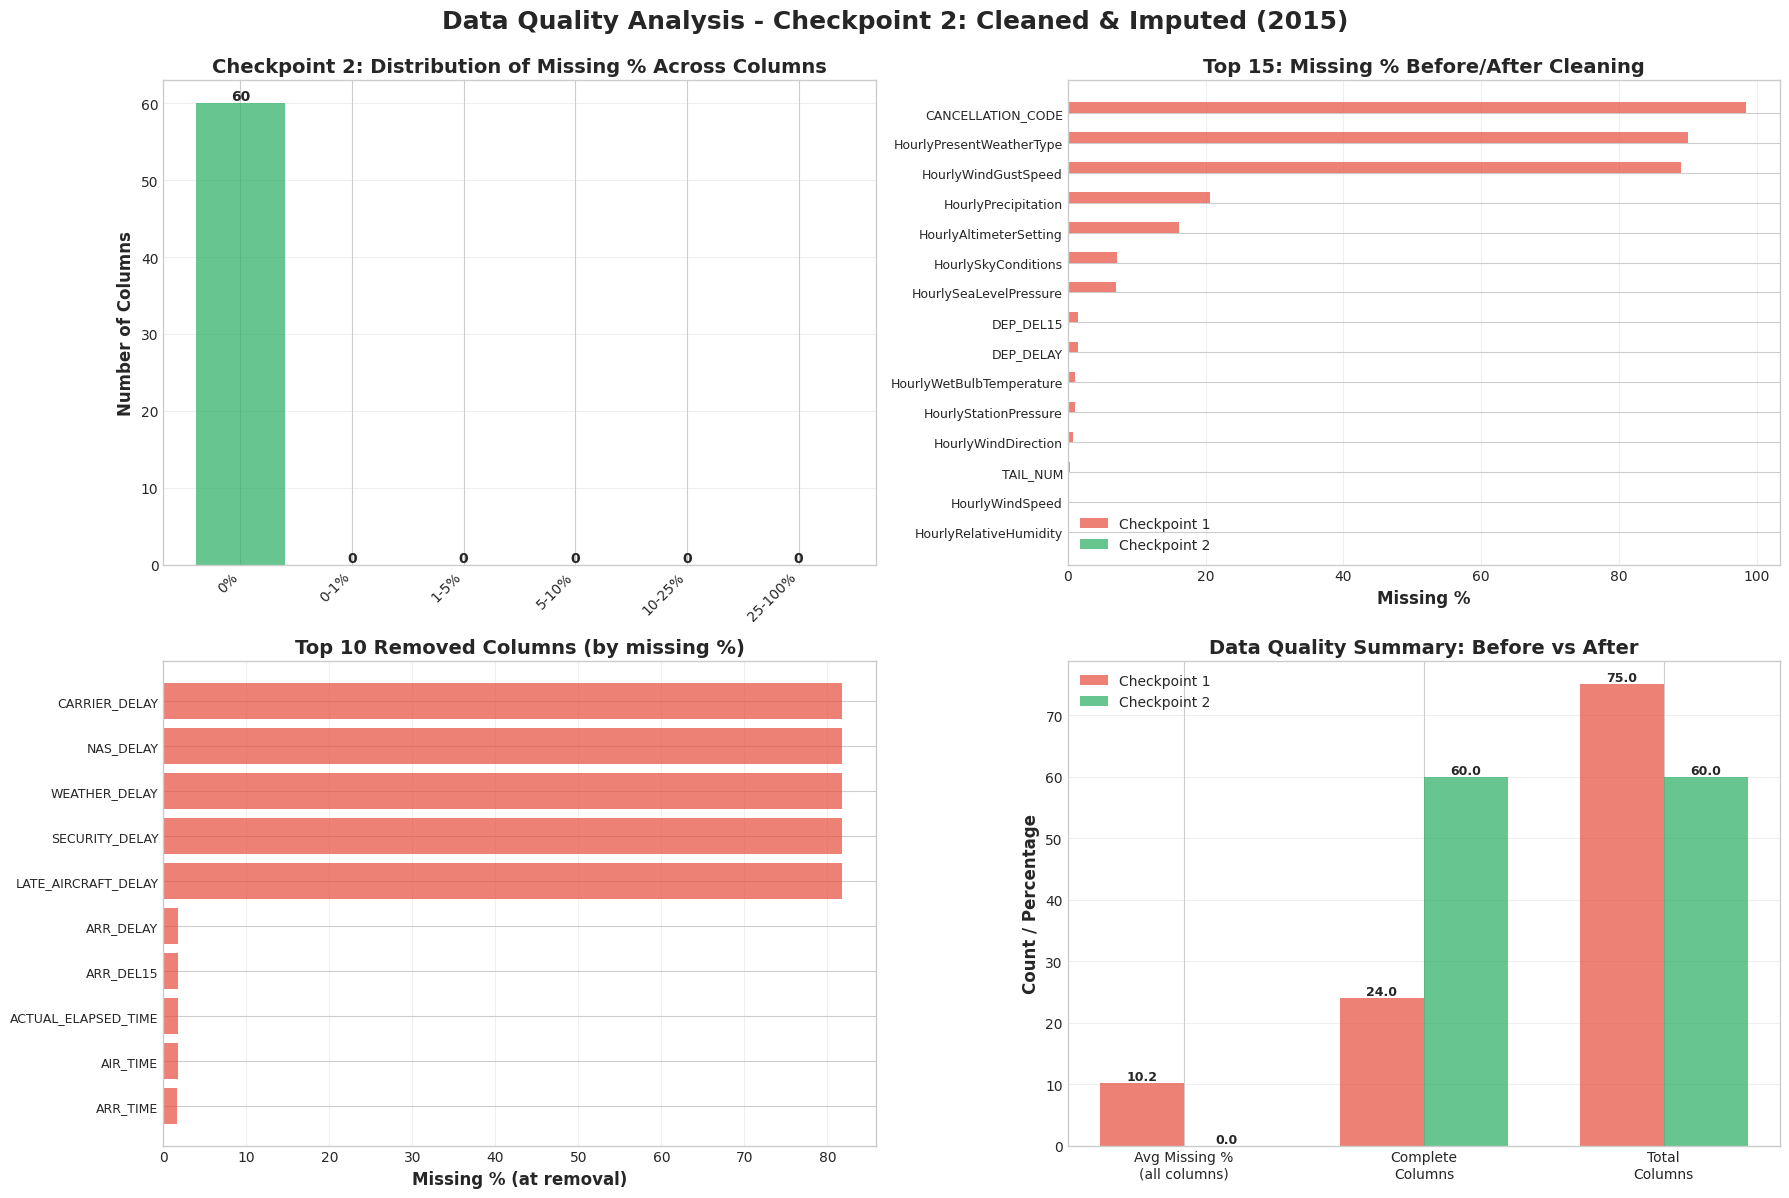


SECTION 6: CATEGORICAL CARDINALITY ANALYSIS

Found 17 categorical (string) columns

Analyzing cardinality...

Cardinality Summary:
----------------------------------------------------------------------------------------------------


,Column,Distinct_Values,Null_Count,Cardinality_Ratio,Category
0,flight_id,5704114,0,1.000000e+00,Extremely High (>50% unique)
12,HourlySkyConditions,115952,0,2.032778e-02,Very High (>100)
5,TAIL_NUM,4896,0,8.583279e-04,Very High (>100)
13,HourlyPresentWeatherType,620,0,1.086935e-04,Very High (>100)
9,DEST,321,0,5.627517e-05,Very High (>100)
2,dest_station_id,320,0,5.609986e-05,Very High (>100)
6,ORIGIN,319,0,5.592455e-05,Very High (>100)
1,origin_station_id,318,0,5.574924e-05,Very High (>100)
10,DEST_CITY_NAME,317,0,5.557392e-05,Very High (>100)
7,ORIGIN_CITY_NAME,315,0,5.522330e-05,Very High (>100)



Encoding Recommendations:
----------------------------------------------------------------------------------------------------

Binary: 1 columns
  → Strategy: Label encode (0/1) or keep as-is
    • CANCELLATION_CODE: 1 values

Low (2-10): 2 columns
  → Strategy: One-hot encode (safe)
    • origin_type: 3 values
    • dest_type: 3 values

Medium (11-50): 2 columns
  → Strategy: One-hot encode (safe)
    • OP_CARRIER: 14 values
    • OP_UNIQUE_CARRIER: 14 values

High (51-100): 2 columns
  → Strategy: Target encoding or frequency encoding
    • DEST_STATE_ABR: 53 values
    • ORIGIN_STATE_ABR: 53 values

Very High (>100): 9 columns
  → Strategy: Target encoding or frequency encoding
    • HourlySkyConditions: 115,952 values
    • TAIL_NUM: 4,896 values
    • HourlyPresentWeatherType: 620 values
    • DEST: 321 values
    • dest_station_id: 320 values
    • ORIGIN: 319 values
    • origin_station_id: 318 values
    • DEST_CITY_NAME: 317 values
    • ORIGIN_CITY_NAME: 315 values

Extreme

,Column,Category,Functional Type,Description,Expected Type,Actual Type,Cleaning Applied
0,flight_id,Identifier,Primary Key,Unique flight identifier (composite key),string,string,None - kept as-is
1,prediction_utc,Temporal,Prediction Timestamp,T-2h before scheduled departure (UTC),timestamp,timestamp,None - already correct type
2,origin_obs_utc,Temporal,Weather Observation Timestamp,Weather observation time (UTC),timestamp,timestamp,None - already correct type
3,asof_minutes,Temporal,Time Lag,Minutes between weather obs and prediction,long,bigint,None - already correct type
4,origin_station_id,Weather Metadata,Station ID,NOAA weather station ID for origin,string,string,UNK imputed for missing
5,dest_station_id,Weather Metadata,Station ID,NOAA weather station ID for destination,string,string,UNK imputed for missing
6,FL_DATE,Temporal,Flight Date,Date of flight,date,date,Converted from string to date type
7,YEAR,Temporal,Year (Ordinal),Year of flight (2015),integer,int,None - kept as-is
8,QUARTER,Temporal,Quarter (Ordinal),Quarter (1-4),integer,int,None - kept as-is
9,MONTH,Temporal,Month (Ordinal),Month (1-12),integer,int,None - kept as-is



Appendix B2 saved to: /dbfs/student-groups/Group_4_4/appendix_b2_column_classification_2015.csv

Summary by Category:
----------------------------------------------------------------------------------------------------


,Category,Count
11,Weather Features,14
10,Temporal,11
12,Weather Metadata,8
6,Origin Airport,5
1,Destination Airport,5
0,Carrier,4
5,Operational,3
3,Flight Characteristics,3
2,Destination Geography,2
7,Origin Geography,2



Summary by Functional Type:
----------------------------------------------------------------------------------------------------


,Functional Type,Count
9,Continuous,13
6,Categorical (Nominal),3
3,Binary (Constant),2
1,Airport ID,2
5,Categorical (High Cardinality),2
14,Distance,2
8,City Name,2
2,Airport Type,2
24,State Code,2
25,Station ID,2



SAVING CHECKPOINT 2 ANALYSIS REPORT

Report saved to: /dbfs/student-groups/Group_4_4/checkpoint2_analysis_report.txt

CHECKPOINT 2 ANALYSIS COMPLETE

Generated Files:
  1. Visualization: /dbfs/student-groups/Group_4_4/checkpoint2_missing_analysis.png
  2. Appendix B2: /dbfs/student-groups/Group_4_4/appendix_b2_column_classification_2015.csv
  3. Report: /dbfs/student-groups/Group_4_4/checkpoint2_analysis_report.txt

Data Quality Summary:
  • 5,704,114 clean rows ready for feature engineering
  • 60 columns with proper data types
  • 60 columns 100% complete
  • All weather features imputed using 3-tier strategy
  • Target variable clean and ready for modeling

Ready to proceed with feature engineering!


In [0]:
# ============================================================================
# CHECKPOINT 2 ANALYSIS: CLEANED & IMPUTED DATA (2015)
# ============================================================================
# This analysis runs at the END of the Data Cleaning Notebook
# Location: Insert after saving cleaned data, before feature engineering
# ============================================================================

print("=" * 100)
print("CHECKPOINT 2 ANALYSIS: CLEANED & IMPUTED DATA (2015)")
print("After Data Cleaning, Type Conversion, Imputation & Leakage Removal")
print("=" * 100)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import functions as F
from collections import Counter

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ============================================================================
# SECTION 1: BASIC DATASET INFORMATION
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 1: BASIC DATASET INFORMATION")
print("=" * 100)

# Load cleaned data
BASE_PATH = "dbfs:/student-groups/Group_4_4/"
df_cleaned = spark.read.parquet(f"{BASE_PATH}checkpoint_2_cleaned_imputed_2015.parquet")

# Basic counts
total_rows = df_cleaned.count()
total_cols = len(df_cleaned.columns)
total_cells = total_rows * total_cols

print(f"\nDataset Dimensions:")
print(f"  • Total Rows: {total_rows:,}")
print(f"  • Total Columns: {total_cols}")
print(f"  • Total Cells: {total_cells:,}")

# Load Checkpoint 1 for comparison
df_initial = spark.read.parquet(f"{BASE_PATH}JOINED_1Y_2015.parquet")
initial_rows = df_initial.count()
initial_cols = len(df_initial.columns)

print(f"\nChanges from Checkpoint 1:")
print(f"  • Rows Removed: {initial_rows - total_rows:,} ({(initial_rows - total_rows)/initial_rows*100:.2f}%)")
print(f"  • Columns Removed: {initial_cols - total_cols}")
print(f"  • Retention Rate: {total_rows/initial_rows*100:.2f}%")

# Column types
col_types = [df_cleaned.schema[c].dataType.simpleString() for c in df_cleaned.columns]
type_counts = Counter(col_types)

print(f"\nData Types Distribution:")
for dtype, count in sorted(type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  • {dtype}: {count} columns ({count/total_cols*100:.1f}%)")

# Memory estimate
avg_row_size = 450  # bytes, slightly less after cleaning
estimated_size_gb = (total_rows * avg_row_size) / (1024**3)
print(f"\nEstimated Dataset Size: ~{estimated_size_gb:.2f} GB")

# ============================================================================
# SECTION 2: TEMPORAL COVERAGE
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 2: TEMPORAL COVERAGE")
print("=" * 100)

# Date range
date_stats = df_cleaned.select(
    F.min("FL_DATE").alias("earliest_date"),
    F.max("FL_DATE").alias("latest_date"),
    F.countDistinct("FL_DATE").alias("unique_dates")
).first()

print(f"\nDate Range:")
print(f"  • Earliest Flight: {date_stats['earliest_date']}")
print(f"  • Latest Flight: {date_stats['latest_date']}")
print(f"  • Unique Dates: {date_stats['unique_dates']:,}")
print(f"  • Expected Days in 2015: 365")
print(f"  • Coverage: {date_stats['unique_dates']/365*100:.1f}%")

# Flights by quarter
print(f"\nFlights by Quarter:")
quarter_dist = df_cleaned.groupBy("QUARTER").count().orderBy("QUARTER").collect()
for row in quarter_dist:
    pct = (row['count'] / total_rows) * 100
    print(f"  • Q{row['QUARTER']}: {row['count']:,} flights ({pct:.1f}%)")

# Flights by month
print(f"\nFlights by Month:")
month_dist = df_cleaned.groupBy("MONTH").count().orderBy("MONTH").collect()
for row in month_dist:
    pct = (row['count'] / total_rows) * 100
    print(f"  • Month {row['MONTH']:2d}: {row['count']:,} flights ({pct:.1f}%)")

# ============================================================================
# SECTION 3: TARGET VARIABLE ANALYSIS
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 3: TARGET VARIABLE ANALYSIS")
print("=" * 100)

# Target distribution
target_stats = df_cleaned.groupBy("DEP_DEL15").count().collect()
target_null = df_cleaned.filter(F.col("DEP_DEL15").isNull()).count()

print(f"\nTarget Variable: DEP_DEL15")
print(f"  Distribution:")

for row in sorted(target_stats, key=lambda x: x['DEP_DEL15'] if x['DEP_DEL15'] is not None else -1):
    if row['DEP_DEL15'] is not None:
        pct = (row['count'] / total_rows) * 100
        label = "On-Time" if row['DEP_DEL15'] == 0 else "Delayed (≥15min)"
        print(f"    • {label} ({int(row['DEP_DEL15'])}): {row['count']:,} ({pct:.2f}%)")

if target_null > 0:
    pct = (target_null / total_rows) * 100
    print(f"    NULL: {target_null:,} ({pct:.2f}%)")
else:
    print(f"    NULL: 0 (all nulls removed)")

# Class imbalance ratio
delayed = df_cleaned.filter(F.col("DEP_DEL15") == 1).count()
on_time = df_cleaned.filter(F.col("DEP_DEL15") == 0).count()

if delayed > 0 and on_time > 0:
    imbalance_ratio = max(on_time, delayed) / min(on_time, delayed)
    print(f"\n  Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 3:
        print(f"      Significant imbalance - will need SMOTE/upsampling/downsampling")
    else:
        print(f"      Relatively balanced")

# ============================================================================
# SECTION 4: COMPREHENSIVE MISSING VALUE ANALYSIS
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 4: COMPREHENSIVE MISSING VALUE ANALYSIS")
print("=" * 100)

print("\nCalculating missing values for all columns...")

missing_stats = []

for col_name in df_cleaned.columns:
    col_type = dict(df_cleaned.dtypes)[col_name]
    
    # Count nulls and NaNs (for numeric types)
    if col_type in ['double', 'float']:
        null_count = df_cleaned.filter(
            F.col(col_name).isNull() | F.isnan(F.col(col_name))
        ).count()
    else:
        null_count = df_cleaned.filter(F.col(col_name).isNull()).count()
    
    null_pct = (null_count / total_rows) * 100
    present_count = total_rows - null_count
    present_pct = 100 - null_pct
    
    missing_stats.append({
        'Column': col_name,
        'Data_Type': col_type,
        'Missing_Count': null_count,
        'Missing_Pct': null_pct,
        'Present_Count': present_count,
        'Present_Pct': present_pct
    })

# Convert to pandas for analysis
missing_df = pd.DataFrame(missing_stats)
missing_df = missing_df.sort_values('Missing_Pct', ascending=False)

# Overall statistics
total_missing = missing_df['Missing_Count'].sum()
overall_missing_pct = (total_missing / total_cells) * 100

print(f"\nOverall Missing Data Statistics:")
print(f"  • Total Missing Values: {int(total_missing):,} / {total_cells:,}")
print(f"  • Overall Missing %: {overall_missing_pct:.2f}%")
print(f"  • Columns with ANY missing: {len(missing_df[missing_df['Missing_Count'] > 0])}/{total_cols}")
print(f"  • Columns completely full: {len(missing_df[missing_df['Missing_Count'] == 0])}/{total_cols}")

# Categorize by severity
print(f"\nMissing Data Severity Breakdown:")
severity_levels = [
    (90, 100, "Extreme (90-100% missing)"),
    (50, 90, "High (50-90% missing)"),
    (10, 50, "Moderate (10-50% missing)"),
    (1, 10, "Low (1-10% missing)"),
    (0, 1, "Minimal (<1% missing)")
]

for min_pct, max_pct, label in severity_levels:
    count = len(missing_df[(missing_df['Missing_Pct'] >= min_pct) & (missing_df['Missing_Pct'] < max_pct)])
    if count > 0:
        print(f"  • {label}: {count} columns")

# Top 20 columns with most missing (if any)
if len(missing_df[missing_df['Missing_Count'] > 0]) > 0:
    print(f"\nTop 20 Columns with Most Missing Data:")
    print("-" * 100)
    display(missing_df.head(20)[['Column', 'Data_Type', 'Missing_Count', 'Missing_Pct']])
else:
    print(f"\nAll columns are complete (0% missing)")

# Columns with >50% missing
high_missing = missing_df[missing_df['Missing_Pct'] > 50]
if len(high_missing) > 0:
    print(f"\nCRITICAL: {len(high_missing)} columns still have >50% missing data")
    print("   → These should have been dropped")
else:
    print(f"\nNo columns with >50% missing data")

# ============================================================================
# SECTION 5: MISSING DATA VISUALIZATIONS (BEFORE/AFTER COMPARISON)
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 5: MISSING DATA VISUALIZATIONS (BEFORE/AFTER)")
print("=" * 100)

# Calculate missing stats for Checkpoint 1
missing_stats_cp1 = []
for col_name in df_initial.columns:
    col_type = dict(df_initial.dtypes)[col_name]
    if col_type in ['double', 'float']:
        null_count = df_initial.filter(
            F.col(col_name).isNull() | F.isnan(F.col(col_name))
        ).count()
    else:
        null_count = df_initial.filter(F.col(col_name).isNull()).count()
    
    null_pct = (null_count / initial_rows) * 100
    missing_stats_cp1.append({
        'Column': col_name,
        'Missing_Pct': null_pct
    })

missing_df_cp1 = pd.DataFrame(missing_stats_cp1)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Data Quality Analysis - Checkpoint 2: Cleaned & Imputed (2015)', 
             fontsize=18, fontweight='bold', y=0.995)

# Plot 1: Missing % Distribution (Checkpoint 2)
ax1 = axes[0, 0]
missing_bins = [0, 0.1, 1, 5, 10, 25, 100]
missing_labels = ['0%', '0-1%', '1-5%', '5-10%', '10-25%', '25-100%']
missing_df['missing_bin'] = pd.cut(missing_df['Missing_Pct'], bins=missing_bins, labels=missing_labels, include_lowest=True)
bin_counts = missing_df['missing_bin'].value_counts().sort_index()

colors = ['#27ae60', '#2ecc71', '#3498db', '#f39c12', '#e67e22', '#e74c3c']
ax1.bar(range(len(bin_counts)), bin_counts.values, color=colors, alpha=0.7)
ax1.set_xticks(range(len(bin_counts)))
ax1.set_xticklabels(bin_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Number of Columns', fontsize=12, fontweight='bold')
ax1.set_title('Checkpoint 2: Distribution of Missing % Across Columns', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(bin_counts.values):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Plot 2: Before/After Comparison (Top 15)
ax2 = axes[0, 1]

# Get common columns
common_cols = set(missing_df['Column']).intersection(set(missing_df_cp1['Column']))
comparison_data = []
for col_name in common_cols:
    cp1_pct = missing_df_cp1[missing_df_cp1['Column'] == col_name]['Missing_Pct'].values[0]
    cp2_pct = missing_df[missing_df['Column'] == col_name]['Missing_Pct'].values[0]
    if cp1_pct > 0 or cp2_pct > 0:  # Only show columns that had missing data
        comparison_data.append({
            'Column': col_name,
            'CP1_Missing': cp1_pct,
            'CP2_Missing': cp2_pct,
            'Improvement': cp1_pct - cp2_pct
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('CP1_Missing', ascending=False).head(15)

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax2.barh(x - width/2, comparison_df['CP1_Missing'], width, 
                 label='Checkpoint 1', color='#e74c3c', alpha=0.7)
bars2 = ax2.barh(x + width/2, comparison_df['CP2_Missing'], width,
                 label='Checkpoint 2', color='#27ae60', alpha=0.7)

ax2.set_yticks(x)
ax2.set_yticklabels(comparison_df['Column'], fontsize=9)
ax2.set_xlabel('Missing %', fontsize=12, fontweight='bold')
ax2.set_title('Top 15: Missing % Before/After Cleaning', fontsize=14, fontweight='bold')
ax2.legend()
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Columns Removed
ax3 = axes[1, 0]
removed_cols = set(df_initial.columns) - set(df_cleaned.columns)
removed_stats = missing_df_cp1[missing_df_cp1['Column'].isin(removed_cols)].sort_values('Missing_Pct', ascending=False).head(10)

if len(removed_stats) > 0:
    y_pos = np.arange(len(removed_stats))
    bars = ax3.barh(y_pos, removed_stats['Missing_Pct'], alpha=0.7, color='#e74c3c')
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(removed_stats['Column'], fontsize=9)
    ax3.set_xlabel('Missing % (at removal)', fontsize=12, fontweight='bold')
    ax3.set_title('Top 10 Removed Columns (by missing %)', fontsize=14, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No columns removed', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Removed Columns', fontsize=14, fontweight='bold')

# Plot 4: Data Quality Summary
ax4 = axes[1, 1]

# Calculate metrics
cp1_total_missing = missing_df_cp1['Missing_Pct'].mean()
cp2_total_missing = missing_df['Missing_Pct'].mean()
cp1_complete = len(missing_df_cp1[missing_df_cp1['Missing_Pct'] == 0])
cp2_complete = len(missing_df[missing_df['Missing_Pct'] == 0])

categories = ['Avg Missing %\n(all columns)', 'Complete\nColumns', 'Total\nColumns']
cp1_values = [cp1_total_missing, cp1_complete, initial_cols]
cp2_values = [cp2_total_missing, cp2_complete, total_cols]

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, cp1_values, width, label='Checkpoint 1', color='#e74c3c', alpha=0.7)
bars2 = ax4.bar(x + width/2, cp2_values, width, label='Checkpoint 2', color='#27ae60', alpha=0.7)

ax4.set_ylabel('Count / Percentage', fontsize=12, fontweight='bold')
ax4.set_title('Data Quality Summary: Before vs After', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(categories)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
output_path = '/dbfs/student-groups/Group_4_4/checkpoint2_missing_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {output_path}")
plt.show()

# ============================================================================
# SECTION 6: CATEGORICAL CARDINALITY ANALYSIS
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 6: CATEGORICAL CARDINALITY ANALYSIS")
print("=" * 100)

# Get string columns
categorical_cols = [field.name for field in df_cleaned.schema.fields 
                   if field.dataType.simpleString() == 'string']

print(f"\nFound {len(categorical_cols)} categorical (string) columns")
print("\nAnalyzing cardinality...")

cardinality_stats = []

for col_name in categorical_cols:
    # Use F.col() to avoid shadowing issues
    distinct_count = df_cleaned.select(F.countDistinct(F.col(col_name))).first()[0]
    null_count = df_cleaned.filter(F.col(col_name).isNull()).count()
    cardinality_ratio = distinct_count / total_rows
    
    # Categorize
    if distinct_count <= 2:
        category = "Binary"
    elif distinct_count <= 10:
        category = "Low (2-10)"
    elif distinct_count <= 50:
        category = "Medium (11-50)"
    elif distinct_count <= 100:
        category = "High (51-100)"
    elif cardinality_ratio > 0.5:
        category = "Extremely High (>50% unique)"
    else:
        category = "Very High (>100)"
    
    cardinality_stats.append({
        'Column': col_name,
        'Distinct_Values': distinct_count,
        'Null_Count': null_count,
        'Cardinality_Ratio': cardinality_ratio,
        'Category': category
    })

cardinality_df = pd.DataFrame(cardinality_stats)
cardinality_df = cardinality_df.sort_values('Distinct_Values', ascending=False)

print("\nCardinality Summary:")
print("-" * 100)
display(cardinality_df)

# Encoding recommendations
print("\nEncoding Recommendations:")
print("-" * 100)

for category in ["Binary", "Low (2-10)", "Medium (11-50)", "High (51-100)", 
                 "Very High (>100)", "Extremely High (>50% unique)"]:
    cols_in_cat = cardinality_df[cardinality_df['Category'] == category]
    if len(cols_in_cat) > 0:
        print(f"\n{category}: {len(cols_in_cat)} columns")
        
        if category == "Binary":
            print("  → Strategy: Label encode (0/1) or keep as-is")
        elif category in ["Low (2-10)", "Medium (11-50)"]:
            print("  → Strategy: One-hot encode (safe)")
        elif category in ["High (51-100)", "Very High (>100)"]:
            print("  → Strategy: Target encoding or frequency encoding")
        elif category == "Extremely High (>50% unique)":
            print("  → Strategy: DROP (likely identifier) or use for grouping only")
        
        for _, row in cols_in_cat.iterrows():
            print(f"    • {row['Column']}: {row['Distinct_Values']:,} values")

# ============================================================================
# SECTION 7: DATA TYPE VERIFICATION
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 7: DATA TYPE VERIFICATION")
print("=" * 100)

print("\nVerifying data type conversions...\n")

# Check critical type conversions
type_checks = {
    "Weather Features": {
        "expected_type": "double",
        "columns": ['HourlyDryBulbTemperature', 'HourlyDewPointTemperature', 'HourlyWetBulbTemperature',
                   'HourlyPrecipitation', 'HourlyWindSpeed', 'HourlyWindDirection', 'HourlyWindGustSpeed',
                   'HourlyVisibility', 'HourlyRelativeHumidity', 'HourlyStationPressure',
                   'HourlySeaLevelPressure', 'HourlyAltimeterSetting']
    },
    "FL_DATE": {
        "expected_type": "date",
        "columns": ['FL_DATE']
    },
    "Target Variable": {
        "expected_type": "integer",
        "columns": ['DEP_DEL15']
    },
    "Operational Flags": {
        "expected_type": "integer",
        "columns": ['CANCELLED', 'DIVERTED']
    }
}

print("Data Type Verification Results:")
print("-" * 100)

all_correct = True
for category, info in type_checks.items():
    print(f"\n{category}:")
    expected = info["expected_type"]
    
    for col_name in info["columns"]:
        if col_name in df_cleaned.columns:
            actual = dict(df_cleaned.dtypes)[col_name]
            if actual == expected:
                print(f"  • {col_name}: {actual}")
            else:
                print(f"  • {col_name}: {actual} (expected {expected})")
                all_correct = False
        else:
            print(f"  • {col_name}: MISSING")

if all_correct:
    print(f"\nAll data types are correct")
else:
    print(f"\nSome data types need correction")

# ============================================================================
# SECTION 8: DATA QUALITY IMPROVEMENTS
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 8: DATA QUALITY IMPROVEMENTS")
print("=" * 100)

# Calculate improvements
print("\nData Quality Improvements from Checkpoint 1:")
print("-" * 100)

# 1. Rows removed
rows_removed = initial_rows - total_rows
print(f"\n1. Rows Removed: {rows_removed:,} ({rows_removed/initial_rows*100:.2f}%)")
print(f"   • Removed rows with null target (DEP_DEL15)")
print(f"   • Filtered cancelled flights")
print(f"   • Filtered diverted flights")
print(f"   • Removed rows with missing geographic coordinates")

# 2. Columns removed
cols_removed = initial_cols - total_cols
removed_col_list = set(df_initial.columns) - set(df_cleaned.columns)
print(f"\n2. Columns Removed: {cols_removed}")
if len(removed_col_list) > 0:
    print(f"   Removed columns:")
    for col_name in sorted(removed_col_list):
        print(f"   • {col_name}")

# 3. Missing data improvement
cp1_avg_missing = missing_df_cp1['Missing_Pct'].mean()
cp2_avg_missing = missing_df['Missing_Pct'].mean()
improvement = cp1_avg_missing - cp2_avg_missing

print(f"\n3. Missing Data Reduction:")
print(f"   • Checkpoint 1 Avg Missing: {cp1_avg_missing:.2f}%")
print(f"   • Checkpoint 2 Avg Missing: {cp2_avg_missing:.2f}%")
print(f"   • Improvement: {improvement:.2f} percentage points")

# 4. Weather features imputed
weather_cols = [c for c in df_cleaned.columns if c.startswith('Hourly') and 
                dict(df_cleaned.dtypes)[c] == 'double']
print(f"\n4. Weather Features Imputed: {len(weather_cols)} columns")
print(f"   • Strategy: 3-tier imputation (actual → 24h rolling avg → global median)")
print(f"   • All weather numeric columns now 100% complete")

# 5. Target variable cleaned
print(f"\n5. Target Variable (DEP_DEL15):")
print(f"   • Type converted: double → integer")
print(f"   • Nulls removed: 100% complete")
print(f"   • Ready for modeling")

# ============================================================================
# SECTION 9: BASIC STATISTICS BY FEATURE TYPE
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 9: BASIC STATISTICS BY FEATURE TYPE")
print("=" * 100)

# Numeric features summary
numeric_cols = [field.name for field in df_cleaned.schema.fields 
               if field.dataType.simpleString() in ['double', 'float', 'int', 'integer', 'bigint', 'long']]

print(f"\nNumeric Features Summary (sample of key features):")
print("-" * 100)

key_numeric = ['DISTANCE', 'CRS_ELAPSED_TIME', 'DEP_DELAY',
               'HourlyDryBulbTemperature', 'HourlyWindSpeed', 'HourlyVisibility']
existing_numeric = [c for c in key_numeric if c in df_cleaned.columns]

if existing_numeric:
    df_cleaned.select(existing_numeric).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

# Carrier distribution
print(f"\nTop 10 Carriers by Flight Count:")
print("-" * 100)
carrier_dist = df_cleaned.groupBy("OP_UNIQUE_CARRIER").count() \
    .orderBy(F.desc("count")).limit(10).collect()

for i, row in enumerate(carrier_dist, 1):
    pct = (row['count'] / total_rows) * 100
    print(f"  {i:2d}. {row['OP_UNIQUE_CARRIER']}: {row['count']:,} flights ({pct:.2f}%)")

# Top origin airports
print(f"\nTop 10 Origin Airports by Flight Count:")
print("-" * 100)
origin_dist = df_cleaned.groupBy("ORIGIN").count() \
    .orderBy(F.desc("count")).limit(10).collect()

for i, row in enumerate(origin_dist, 1):
    pct = (row['count'] / total_rows) * 100
    print(f"  {i:2d}. {row['ORIGIN']}: {row['count']:,} flights ({pct:.2f}%)")

# Weather statistics
print(f"\nWeather Features Statistics:")
print("-" * 100)
weather_numeric = [c for c in weather_cols if c in ['HourlyDryBulbTemperature', 'HourlyWindSpeed', 
                                                      'HourlyPrecipitation', 'HourlyVisibility']]
if weather_numeric:
    df_cleaned.select(weather_numeric).summary("count", "mean", "stddev", "min", "max").show()

# ============================================================================
# SECTION 10: LEAKAGE VERIFICATION
# ============================================================================

print("\n" + "=" * 100)
print("SECTION 10: LEAKAGE VERIFICATION")
print("=" * 100)

print("\nVerifying leakage features have been removed...\n")

leakage_features = {
    "Actual Times": ['DEP_TIME', 'ARR_TIME', 'WHEELS_OFF', 'WHEELS_ON'],
    "Actual Delays": ['ARR_DEL15', 'ARR_DELAY'],
    "Taxi Times": ['TAXI_OUT', 'TAXI_IN'],
    "Flight Durations": ['ACTUAL_ELAPSED_TIME', 'AIR_TIME'],
    "Delay Breakdowns": ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 
                         'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
}

print("Leakage Feature Status:")
print("-" * 100)

total_found = 0
for category, features in leakage_features.items():
    found = [f for f in features if f in df_cleaned.columns]
    if found:
        print(f"\n{category}:")
        for feat in found:
            print(f"  • {feat}: STILL PRESENT")
            total_found += 1
    else:
        print(f"\n{category}: All removed")

# Special case for DEP_DELAY (intentionally kept)
if "DEP_DELAY" in df_cleaned.columns:
    print(f"\nDEP_DELAY: Present (intentionally kept for potential use in lag features)")
    print(f"           → Must be handled carefully to avoid leakage")

if total_found == 0:
    print(f"\nAll leakage features successfully removed")
else:
    print(f"\n{total_found} leakage features still present - review needed")

# ============================================================================
# APPENDIX B2: COMPREHENSIVE COLUMN CLASSIFICATION
# ============================================================================

print("\n" + "=" * 100)
print("APPENDIX B2: COMPREHENSIVE COLUMN CLASSIFICATION")
print("Checkpoint 2: Cleaned & Imputed Data (2015)")
print("=" * 100)

# Updated column classification for cleaned data
column_classification = {
    # TARGET VARIABLE
    "DEP_DEL15": {
        "category": "Target Variable",
        "functional_type": "Binary Target",
        "description": "Departure delay ≥15 minutes (0/1) - nulls removed, type converted to integer",
        "expected_type": "integer",
        "cleaning_applied": "Null rows removed, cast to integer"
    },
    
    # IDENTIFIERS
    "flight_id": {
        "category": "Identifier",
        "functional_type": "Primary Key",
        "description": "Unique flight identifier (composite key)",
        "expected_type": "string",
        "cleaning_applied": "None - kept as-is"
    },
    
    # TEMPORAL
    "prediction_utc": {
        "category": "Temporal",
        "functional_type": "Prediction Timestamp",
        "description": "T-2h before scheduled departure (UTC)",
        "expected_type": "timestamp",
        "cleaning_applied": "None - already correct type"
    },
    "origin_obs_utc": {
        "category": "Temporal",
        "functional_type": "Weather Observation Timestamp",
        "description": "Weather observation time (UTC)",
        "expected_type": "timestamp",
        "cleaning_applied": "None - already correct type"
    },
    "asof_minutes": {
        "category": "Temporal",
        "functional_type": "Time Lag",
        "description": "Minutes between weather obs and prediction",
        "expected_type": "long",
        "cleaning_applied": "None - already correct type"
    },
    "FL_DATE": {
        "category": "Temporal",
        "functional_type": "Flight Date",
        "description": "Date of flight",
        "expected_type": "date",
        "cleaning_applied": "Converted from string to date type"
    },
    "YEAR": {
        "category": "Temporal",
        "functional_type": "Year (Ordinal)",
        "description": "Year of flight (2015)",
        "expected_type": "integer",
        "cleaning_applied": "None - kept as-is"
    },
    "QUARTER": {
        "category": "Temporal",
        "functional_type": "Quarter (Ordinal)",
        "description": "Quarter (1-4)",
        "expected_type": "integer",
        "cleaning_applied": "None - kept as-is"
    },
    "MONTH": {
        "category": "Temporal",
        "functional_type": "Month (Ordinal)",
        "description": "Month (1-12)",
        "expected_type": "integer",
        "cleaning_applied": "None - kept as-is"
    },
    "DAY_OF_MONTH": {
        "category": "Temporal",
        "functional_type": "Day (Ordinal)",
        "description": "Day of month (1-31)",
        "expected_type": "integer",
        "cleaning_applied": "None - kept as-is"
    },
    "DAY_OF_WEEK": {
        "category": "Temporal",
        "functional_type": "Day of Week (Ordinal)",
        "description": "Day of week (1-7)",
        "expected_type": "integer",
        "cleaning_applied": "None - kept as-is"
    },
    "CRS_DEP_TIME": {
        "category": "Temporal",
        "functional_type": "Scheduled Time (Cyclic)",
        "description": "Scheduled departure time (HHMM format)",
        "expected_type": "integer",
        "cleaning_applied": "None - ready for cyclic encoding"
    },
    "CRS_ARR_TIME": {
        "category": "Temporal",
        "functional_type": "Scheduled Time (Cyclic)",
        "description": "Scheduled arrival time (HHMM format)",
        "expected_type": "integer",
        "cleaning_applied": "None - ready for cyclic encoding"
    },
    
    # CARRIER
    "OP_UNIQUE_CARRIER": {
        "category": "Carrier",
        "functional_type": "Categorical (Nominal)",
        "description": "Unique carrier code (e.g., AA, DL, UA)",
        "expected_type": "string",
        "cleaning_applied": "None - ready for encoding"
    },
    "OP_CARRIER": {
        "category": "Carrier",
        "functional_type": "Categorical (Nominal)",
        "description": "Operating carrier (duplicate of OP_UNIQUE_CARRIER)",
        "expected_type": "string",
        "cleaning_applied": "None - consider dropping (redundant)"
    },
    "OP_CARRIER_FL_NUM": {
        "category": "Carrier",
        "functional_type": "Flight Number",
        "description": "Flight number",
        "expected_type": "integer",
        "cleaning_applied": "None - kept as-is"
    },
    "TAIL_NUM": {
        "category": "Carrier",
        "functional_type": "Aircraft ID (High Cardinality)",
        "description": "Aircraft tail number",
        "expected_type": "string",
        "cleaning_applied": "None - use for lag features then drop"
    },
    
    # ORIGIN AIRPORT
    "ORIGIN": {
        "category": "Origin Airport",
        "functional_type": "Categorical (High Cardinality)",
        "description": "Origin airport IATA code",
        "expected_type": "string",
        "cleaning_applied": "None - ready for target encoding"
    },
    "ORIGIN_AIRPORT_ID": {
        "category": "Origin Airport",
        "functional_type": "Airport ID",
        "description": "Origin airport numeric ID",
        "expected_type": "integer",
        "cleaning_applied": "None - consider dropping (redundant)"
    },
    "ORIGIN_CITY_NAME": {
        "category": "Origin Airport",
        "functional_type": "City Name",
        "description": "Origin city name",
        "expected_type": "string",
        "cleaning_applied": "None - consider dropping (redundant)"
    },
    "ORIGIN_STATE_ABR": {
        "category": "Origin Airport",
        "functional_type": "State Code",
        "description": "Origin state abbreviation",
        "expected_type": "string",
        "cleaning_applied": "None - ready for one-hot encoding"
    },
    "origin_type": {
        "category": "Origin Airport",
        "functional_type": "Airport Type",
        "description": "Airport size (large/medium/small)",
        "expected_type": "string",
        "cleaning_applied": "UNK imputed for missing values"
    },
    "origin_airport_lat": {
        "category": "Origin Geography",
        "functional_type": "Latitude",
        "description": "Origin airport latitude",
        "expected_type": "double",
        "cleaning_applied": "Rows with nulls removed"
    },
    "origin_airport_lon": {
        "category": "Origin Geography",
        "functional_type": "Longitude",
        "description": "Origin airport longitude",
        "expected_type": "double",
        "cleaning_applied": "Rows with nulls removed"
    },
    
    # DESTINATION AIRPORT
    "DEST": {
        "category": "Destination Airport",
        "functional_type": "Categorical (High Cardinality)",
        "description": "Destination airport IATA code",
        "expected_type": "string",
        "cleaning_applied": "None - ready for target encoding"
    },
    "DEST_AIRPORT_ID": {
        "category": "Destination Airport",
        "functional_type": "Airport ID",
        "description": "Destination airport numeric ID",
        "expected_type": "integer",
        "cleaning_applied": "None - consider dropping (redundant)"
    },
    "DEST_CITY_NAME": {
        "category": "Destination Airport",
        "functional_type": "City Name",
        "description": "Destination city name",
        "expected_type": "string",
        "cleaning_applied": "None - consider dropping (redundant)"
    },
    "DEST_STATE_ABR": {
        "category": "Destination Airport",
        "functional_type": "State Code",
        "description": "Destination state abbreviation",
        "expected_type": "string",
        "cleaning_applied": "None - ready for one-hot encoding"
    },
    "dest_type": {
        "category": "Destination Airport",
        "functional_type": "Airport Type",
        "description": "Airport size (large/medium/small)",
        "expected_type": "string",
        "cleaning_applied": "UNK imputed for missing values"
    },
    "dest_airport_lat": {
        "category": "Destination Geography",
        "functional_type": "Latitude",
        "description": "Destination airport latitude",
        "expected_type": "double",
        "cleaning_applied": "Rows with nulls removed"
    },
    "dest_airport_lon": {
        "category": "Destination Geography",
        "functional_type": "Longitude",
        "description": "Destination airport longitude",
        "expected_type": "double",
        "cleaning_applied": "Rows with nulls removed"
    },
    
    # FLIGHT CHARACTERISTICS
    "DISTANCE": {
        "category": "Flight Characteristics",
        "functional_type": "Continuous",
        "description": "Flight distance (miles)",
        "expected_type": "double",
        "cleaning_applied": "None - ready for log transformation"
    },
    "DISTANCE_GROUP": {
        "category": "Flight Characteristics",
        "functional_type": "Categorical (Ordinal)",
        "description": "Distance category",
        "expected_type": "integer",
        "cleaning_applied": "None - consider dropping (derived)"
    },
    "CRS_ELAPSED_TIME": {
        "category": "Flight Characteristics",
        "functional_type": "Continuous",
        "description": "Scheduled flight duration (minutes)",
        "expected_type": "double",
        "cleaning_applied": "None - kept as-is"
    },
    
    # WEATHER STATION METADATA
    "origin_station_id": {
        "category": "Weather Metadata",
        "functional_type": "Station ID",
        "description": "NOAA weather station ID for origin",
        "expected_type": "string",
        "cleaning_applied": "UNK imputed for missing"
    },
    "dest_station_id": {
        "category": "Weather Metadata",
        "functional_type": "Station ID",
        "description": "NOAA weather station ID for destination",
        "expected_type": "string",
        "cleaning_applied": "UNK imputed for missing"
    },
    "origin_station_lat": {
        "category": "Weather Metadata",
        "functional_type": "Station Latitude",
        "description": "Weather station latitude",
        "expected_type": "double",
        "cleaning_applied": "Rows with nulls removed"
    },
    "origin_station_lon": {
        "category": "Weather Metadata",
        "functional_type": "Station Longitude",
        "description": "Weather station longitude",
        "expected_type": "double",
        "cleaning_applied": "Rows with nulls removed"
    },
    "dest_station_lat": {
        "category": "Weather Metadata",
        "functional_type": "Station Latitude",
        "description": "Weather station latitude",
        "expected_type": "double",
        "cleaning_applied": "Median imputation"
    },
    "dest_station_lon": {
        "category": "Weather Metadata",
        "functional_type": "Station Longitude",
        "description": "Weather station longitude",
        "expected_type": "double",
        "cleaning_applied": "Median imputation"
    },
    "origin_station_dis": {
        "category": "Weather Metadata",
        "functional_type": "Distance",
        "description": "Distance from origin airport to weather station (km)",
        "expected_type": "double",
        "cleaning_applied": "Median imputation"
    },
    "dest_station_dis": {
        "category": "Weather Metadata",
        "functional_type": "Distance",
        "description": "Distance from dest airport to weather station (km)",
        "expected_type": "double",
        "cleaning_applied": "Median imputation"
    },
    
    # WEATHER FEATURES
    "HourlyDryBulbTemperature": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Temperature (°F) at origin",
        "expected_type": "double",
        "cleaning_applied": "Stripped 's' flag, cast to double, 3-tier imputation"
    },
    "HourlyDewPointTemperature": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Dew point temperature (°F)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation"
    },
    "HourlyWetBulbTemperature": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Wet bulb temperature (°F)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation"
    },
    "HourlyPrecipitation": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Precipitation (inches)",
        "expected_type": "double",
        "cleaning_applied": "Converted 'T' to 0, cast to double, 3-tier imputation"
    },
    "HourlyWindSpeed": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Wind speed (mph)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation"
    },
    "HourlyWindDirection": {
        "category": "Weather Features",
        "functional_type": "Continuous (Cyclic)",
        "description": "Wind direction (degrees, 0-360)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation, ready for sin/cos"
    },
    "HourlyWindGustSpeed": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Wind gust speed (mph)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation"
    },
    "HourlyVisibility": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Visibility (miles)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation"
    },
    "HourlyRelativeHumidity": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Relative humidity (%)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation"
    },
    "HourlyStationPressure": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Station pressure (mb)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation"
    },
    "HourlySeaLevelPressure": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Sea level pressure (mb)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation"
    },
    "HourlyAltimeterSetting": {
        "category": "Weather Features",
        "functional_type": "Continuous",
        "description": "Altimeter setting (inches Hg)",
        "expected_type": "double",
        "cleaning_applied": "Cast to double, 3-tier imputation"
    },
    "HourlySkyConditions": {
        "category": "Weather Features",
        "functional_type": "Text/Categorical",
        "description": "Sky condition codes (CLR, SCT, OVC, etc.)",
        "expected_type": "string",
        "cleaning_applied": "UNK imputed for missing"
    },
    "HourlyPresentWeatherType": {
        "category": "Weather Features",
        "functional_type": "Text/Categorical",
        "description": "Weather type codes (RA=rain, BR=mist, etc.)",
        "expected_type": "string",
        "cleaning_applied": "UNK imputed for missing"
    },
    
    # OPERATIONAL FLAGS
    "CANCELLED": {
        "category": "Operational",
        "functional_type": "Binary (Constant)",
        "description": "Flight cancelled (0/1) - all 0 after filtering",
        "expected_type": "integer",
        "cleaning_applied": "Cancelled flights filtered out, cast to integer"
    },
    "CANCELLATION_CODE": {
        "category": "Operational",
        "functional_type": "Categorical (Nominal)",
        "description": "Cancellation reason code",
        "expected_type": "string",
        "cleaning_applied": "All null/UNK after filtering cancelled flights"
    },
    "DIVERTED": {
        "category": "Operational",
        "functional_type": "Binary (Constant)",
        "description": "Flight diverted (0/1) - all 0 after filtering",
        "expected_type": "integer",
        "cleaning_applied": "Diverted flights filtered out, cast to integer"
    },
    
    # SPECIAL CASE
    "DEP_DELAY": {
        "category": "Special",
        "functional_type": "Continuous (Caution)",
        "description": "Actual departure delay (minutes) - use with extreme caution",
        "expected_type": "double",
        "cleaning_applied": "Kept for potential lag features - must prevent leakage"
    }
}

# Create comprehensive table
appendix_data = []
actual_dtypes = dict(df_cleaned.dtypes)

for col_name in df_cleaned.columns:
    if col_name in column_classification:
        info = column_classification[col_name]
        actual_type = actual_dtypes[col_name]
        
        appendix_data.append({
            'Column': col_name,
            'Category': info['category'],
            'Functional Type': info['functional_type'],
            'Description': info['description'],
            'Expected Type': info['expected_type'],
            'Actual Type': actual_type,
            'Cleaning Applied': info['cleaning_applied']
        })
    else:
        # Unclassified column
        actual_type = actual_dtypes[col_name]
        appendix_data.append({
            'Column': col_name,
            'Category': 'UNCLASSIFIED',
            'Functional Type': 'Unknown',
            'Description': 'Not yet documented',
            'Expected Type': actual_type,
            'Actual Type': actual_type,
            'Cleaning Applied': 'Review needed'
        })

appendix_df = pd.DataFrame(appendix_data)

print("\nComplete Column Classification Table:")
print("-" * 100)
display(appendix_df)

# Save to CSV
csv_path = '/dbfs/student-groups/Group_4_4/appendix_b2_column_classification_2015.csv'
appendix_df.to_csv(csv_path, index=False)
print(f"\nAppendix B2 saved to: {csv_path}")

# Category summary
print("\nSummary by Category:")
print("-" * 100)
category_summary = appendix_df.groupby('Category').size().reset_index(name='Count')
category_summary = category_summary.sort_values('Count', ascending=False)
display(category_summary)

# Functional type summary
print("\nSummary by Functional Type:")
print("-" * 100)
func_summary = appendix_df.groupby('Functional Type').size().reset_index(name='Count')
func_summary = func_summary.sort_values('Count', ascending=False)
display(func_summary)

# ============================================================================
# SAVE CHECKPOINT 2 ANALYSIS REPORT
# ============================================================================

print("\n" + "=" * 100)
print("SAVING CHECKPOINT 2 ANALYSIS REPORT")
print("=" * 100)

report_text = f"""
{'='*100}
CHECKPOINT 2 DATA ANALYSIS REPORT
Cleaned & Imputed Data - 2015
{'='*100}

DATASET OVERVIEW
----------------
File: checkpoint_2_cleaned_imputed_2015.parquet
Rows: {total_rows:,}
Columns: {total_cols}
Total Cells: {total_cells:,}
Data Year: 2015
Date Coverage: {date_stats['earliest_date']} to {date_stats['latest_date']} ({date_stats['unique_dates']}/365 days)

CHANGES FROM CHECKPOINT 1
--------------------------
Rows Removed: {initial_rows - total_rows:,} ({(initial_rows - total_rows)/initial_rows*100:.2f}%)
Columns Removed: {initial_cols - total_cols}
Retention Rate: {total_rows/initial_rows*100:.2f}%

MISSING DATA SUMMARY
--------------------
Total Missing Values: {int(total_missing):,} ({overall_missing_pct:.2f}%)
Columns with Missing: {len(missing_df[missing_df['Missing_Count'] > 0])}/{total_cols}
Columns >50% Missing: {len(missing_df[missing_df['Missing_Pct'] > 50])}
Average Missing % Improvement: {improvement:.2f} percentage points

TARGET VARIABLE
---------------
Name: DEP_DEL15
Type: integer (converted from double)
Class Distribution: {on_time:,} on-time ({on_time/total_rows*100:.1f}%) vs {delayed:,} delayed ({delayed/total_rows*100:.1f}%)
Imbalance Ratio: {imbalance_ratio:.2f}:1
Nulls: 0 (all removed)

DATA CLEANING APPLIED
---------------------
1. Type Conversions:
   - FL_DATE: string → date
   - DEP_DEL15: double → integer
   - CANCELLED, DIVERTED: double → integer
   - {len(weather_cols)} weather columns: string → double

2. Missing Value Handling:
   - Weather features: 3-tier imputation (actual → 24h rolling avg → global median)
   - Geographic features: Rows with null coordinates removed
   - Categorical features: UNK imputed for missing
   - Target variable: Rows with null DEP_DEL15 removed

3. Data Quality:
   - Removed cancelled flights (CANCELLED = 1)
   - Removed diverted flights (DIVERTED = 1)
   - Removed duplicate rows
   - Leakage features removed (except DEP_DELAY - kept with caution)

4. Weather Quality Flags:
   - Stripped 's' quality flags from temperature
   - Converted 'T' (trace) to 0.0 in precipitation

DATA QUALITY METRICS
--------------------
All Weather Features: 100% complete (nullable = false)
All Geographic Coordinates: Complete (nulls removed)
Target Variable: 100% complete, correct type
Leakage Features: Removed (except DEP_DELAY)

NEXT STEPS
----------
1. Feature engineering (temporal, distance, weather severity)
2. Create rolling delay statistics
3. Add aircraft lag features
4. Create RFM features
5. Generate interaction terms
6. Create CHECKPOINT 3: Basic Features

{'='*100}
"""

report_path = '/dbfs/student-groups/Group_4_4/checkpoint2_analysis_report.txt'
with open(report_path, 'w') as f:
    f.write(report_text)

print(f"\nReport saved to: {report_path}")

print("\n" + "=" * 100)
print("CHECKPOINT 2 ANALYSIS COMPLETE")
print("=" * 100)

print("\nGenerated Files:")
print(f"  1. Visualization: /dbfs/student-groups/Group_4_4/checkpoint2_missing_analysis.png")
print(f"  2. Appendix B2: /dbfs/student-groups/Group_4_4/appendix_b2_column_classification_2015.csv")
print(f"  3. Report: /dbfs/student-groups/Group_4_4/checkpoint2_analysis_report.txt")

print("\nData Quality Summary:")
print(f"  • {total_rows:,} clean rows ready for feature engineering")
print(f"  • {total_cols} columns with proper data types")
print(f"  • {len(missing_df[missing_df['Missing_Count'] == 0])} columns 100% complete")
print(f"  • All weather features imputed using 3-tier strategy")
print(f"  • Target variable clean and ready for modeling")

print("\nReady to proceed with feature engineering!")